In [1]:
import gc
import os
import random
import re
import statistics as st
import warnings
from collections import Counter

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from gensim.models import Word2Vec
from scipy.stats import kurtosis, rankdata, skew
from sklearn import metrics, model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.autonotebook import tqdm
from xgboost import plot_importance

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
class Config:
    INPUT_DIR = "./data"
    seed = 42
    is_time_in_secs = True
    time_divider = 1000 if is_time_in_secs else 1

    num_folds = 10
    num_estimators = 12001
    num_trials_early_stopping = 200

    response_variate = "score"
    use_optuna_tuning = True
    val_size_ranker = 0.2
    num_trials_optuna = 40
    num_trials_optuna_ranker = 50

    num_features_to_display = 50

In [66]:
cnfg = Config()

In [4]:
tqdm.pandas()
sns.set_style("whitegrid")
warnings.simplefilter("ignore")
random.seed(cnfg.seed)

In [5]:
train_logs = pd.read_csv(f"{cnfg.INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{cnfg.INPUT_DIR}/train_scores.csv")
test_logs = pd.read_csv(f"{cnfg.INPUT_DIR}/test_logs.csv")

In [6]:
train_logs.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count'],
      dtype='object')

### Utils ###

In [7]:
def my_max(lst):
    try:
        x = max(lst)
    except:
        x = 0
    return x


def my_min(lst):
    try:
        x = min(lst)
    except:
        x = 0
    return x


def my_mean(lst):
    try:
        x = np.mean(lst)
    except:
        x = 0
    return x


def my_std(lst):
    try:
        x = st.stdev(lst)
    except:
        x = 0
    return x


def my_skew(lst):
    try:
        x = skew(lst)
    except:
        x = 0
    return x


def my_kurtosis(lst):
    try:
        x = kurtosis(lst)
    except:
        x = 0
    return x


def my_median_grouped(lst):
    try:
        x = st.median_grouped(lst)
    except:
        x = 0
    return x


def my_sum(lst):
    try:
        x = sum(lst)
    except:
        x = 0
    return x


def q1(x):
    return x.quantile(0.25)


def q3(x):
    return x.quantile(0.75)

### Pre-processing ###

In [8]:
class Preprocessor:
    def __init__(self, seed, df):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.activities_name_mapping = {
            "Input": "input",
            "Remove/Cut": "remove",
            "Nonproduction": "non_production",
            "Replace": "replace",
            "Paste": "paste",
        }
        self.text_changes = text_changes = [
            "q",
            " ",
            # "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.special_character_name_mapping = special_character_name_mapping = {
            "'": "qoute",
            '"': "double_qoute",
            ".": "full_stop",
            ",": "comma",
            "-": "hyphen",
            "?": "question_mark",
            ";": "semi_colon",
            "=": "equal_to",
            "/": "forward_slash",
            "\\": "back_slash",
            ":": "colon",
            "(": "bracket_open",
            ")": "bracket_close",
            "!": "exclamation_mark",
            "[": "square_bracket_open",
            "$": "dollar",
            ">": "greater_than_sign",
            "]": "square_bracket_close",
            "*": "star",
            "%": "percentage",
            "&": "ampresand",
            "<": "less_than_sign",
            "+": "plus_sign",
            "_": "under_score",
            "{": "curly_bracket_open",
            "`": "tilted_qoute",
            "#": "hashtag",
            " ": "blank_space",
            "\n": "new_line_char",
        }
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        self.df = df.sort_values(["id", "event_id"]).reset_index(drop=True)
        self.AGGREGATIONS = [
            "count",
            "mean",
            "std",
            "min",
            "max",
            "first",
            "last",
            "sem",
            q1,
            "median",
            q3,
            "skew",
            # pd.DataFrame.kurt,
            "sum",
        ]

    def remove_lower_categorical_values(self):
        ## Clean activity
        self.df["activity"] = self.df.activity.apply(
            lambda x: x if x in self.activities else "__OUTLIER__"
        )

    def clean_up_time(self):
        """
        For maximum number of ids uptime is not increasing. In each id for one or two events, up_time is incorrectly recorded
        Procedure: Calculate the difference with next if diff is negative replace up_time with the up_time of next.
        """
        print(f"Before uptime cleaning, data shape: {self.df.shape}")
        tmp_df = self.df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time

        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        # Do it once more
        tmp_df = tmp_df[["id", "event_id", "up_time"]]
        tmp_df["up_time_next"] = tmp_df.groupby("id").up_time.shift(-1)
        tmp_df["up_time_diff"] = tmp_df["up_time_next"] - tmp_df.up_time
        tmp_df.loc[tmp_df[tmp_df.up_time_diff < 0].index, "up_time"] = tmp_df[
            tmp_df.up_time_diff < 0
        ].up_time_next

        self.df["up_time"] = tmp_df["up_time"]
        print(f"After uptime cleaning, data shape: {self.df.shape}")

    def add_latency_columns(self):
        # HL -> Hold latency, up_time-down_time
        # IL-> Interkey latency -> down_time(event2) - up_time(event1)
        # PL -> Press latency -> down_time(event2)- down_time(event1) or HL+IL
        # RL -> Release Latency -> up_time(event2)- up_time(event1)
        # self.df["HL"] = self.df["up_time"] - self.df["down_time"] #same as action_time
        self.df["IL"] = self.df["down_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["IL"] = self.df["IL"].fillna(0)
        self.df["PL"] = self.df["down_time"] - self.df.groupby("id").down_time.shift(
            1
        ).fillna(self.df.down_time)
        # self.df["PL"] = self.df["PL"].fillna(0)
        self.df["RL"] = self.df["up_time"] - self.df.groupby("id").up_time.shift(
            1
        ).fillna(self.df.up_time)
        # self.df["RL"] = self.df["RL"].fillna(0)

        # self.df = self.df[~self.df.isna().any(axis=1)].reset_index(drop=True)

    def clean_data(self):
        self.remove_lower_categorical_values()
        self.clean_up_time()

        self.add_latency_columns()

    def change_time_columns_to_secs(self):
        time_columns = ["down_time", "up_time", "action_time", "IL", "PL", "RL"]
        for clm in time_columns:
            self.df[clm] = self.df[clm] / cnfg.time_divider

    # Function to construct essays copied from here: https://www.kaggle.com/code/kawaiicoderuwu/essay-contructor
    def getEssays(self):
        textInputDf = self.df[["id", "activity", "cursor_position", "text_change"]]
        textInputDf = textInputDf[textInputDf.activity != "Nonproduction"]
        valCountsArr = textInputDf["id"].value_counts(sort=False).values
        lastIndex = 0
        essaySeries = pd.Series()
        for index, valCount in enumerate(valCountsArr):
            currTextInput = textInputDf[
                ["activity", "cursor_position", "text_change"]
            ].iloc[lastIndex : lastIndex + valCount]
            lastIndex += valCount
            essayText = ""
            for Input in currTextInput.values:
                if Input[0] == "Replace":
                    replaceTxt = Input[2].split(" => ")
                    essayText = (
                        essayText[: Input[1] - len(replaceTxt[1])]
                        + replaceTxt[1]
                        + essayText[
                            Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]) :
                        ]
                    )
                    continue
                if Input[0] == "Paste":
                    essayText = (
                        essayText[: Input[1] - len(Input[2])]
                        + Input[2]
                        + essayText[Input[1] - len(Input[2]) :]
                    )
                    continue
                if Input[0] == "Remove/Cut":
                    essayText = (
                        essayText[: Input[1]] + essayText[Input[1] + len(Input[2]) :]
                    )
                    continue
                if "M" in Input[0]:
                    croppedTxt = Input[0][10:]
                    splitTxt = croppedTxt.split(" To ")
                    valueArr = [item.split(", ") for item in splitTxt]
                    moveData = (
                        int(valueArr[0][0][1:]),
                        int(valueArr[0][1][:-1]),
                        int(valueArr[1][0][1:]),
                        int(valueArr[1][1][:-1]),
                    )
                    if moveData[0] != moveData[2]:
                        if moveData[0] < moveData[2]:
                            essayText = (
                                essayText[: moveData[0]]
                                + essayText[moveData[1] : moveData[3]]
                                + essayText[moveData[0] : moveData[1]]
                                + essayText[moveData[3] :]
                            )
                        else:
                            essayText = (
                                essayText[: moveData[2]]
                                + essayText[moveData[0] : moveData[1]]
                                + essayText[moveData[2] : moveData[0]]
                                + essayText[moveData[1] :]
                            )
                    continue
                essayText = (
                    essayText[: Input[1] - len(Input[2])]
                    + Input[2]
                    + essayText[Input[1] - len(Input[2]) :]
                )
            essaySeries[index] = essayText
        essaySeries.index = textInputDf["id"].unique()

        essay_df = (
            pd.DataFrame(essaySeries, columns=["essay"])
            .reset_index()
            .rename(columns={"index": "id"})
        )

        self.essay_df = essay_df
        return

    def split_essays_into_sentences(self):
        essay_df = self.essay_df
        essay_df["sent"] = essay_df["essay"].apply(lambda x: re.split("\\.|\\?|\\!", x))
        essay_df = essay_df.explode("sent")
        essay_df["sent"] = essay_df["sent"].apply(lambda x: x.replace("\n", "").strip())
        # Number of characters in sentences
        essay_df["sent_len"] = essay_df["sent"].apply(lambda x: len(x))
        # Number of words in sentences
        essay_df["sent_word_count"] = essay_df["sent"].apply(
            lambda x: len(x.split(" "))
        )
        essay_df = essay_df[essay_df.sent_len != 0].reset_index(drop=True)
        self.sent_df = essay_df
        return

    def split_essays_into_paragraphs(self):
        essay_df = self.essay_df
        essay_df["paragraph"] = essay_df["essay"].apply(lambda x: x.split("\n"))
        essay_df = essay_df.explode("paragraph")
        # Number of characters in paragraphs
        essay_df["paragraph_len"] = essay_df["paragraph"].apply(lambda x: len(x))
        # Number of words in paragraphs
        essay_df["paragraph_word_count"] = essay_df["paragraph"].apply(
            lambda x: len(x.split(" "))
        )
        essay_df = essay_df[essay_df.paragraph_len != 0].reset_index(drop=True)

        self.para_df = essay_df
        return

    def compute_sentence_aggregations(self, tmp_df):
        sent_agg_df = pd.concat(
            [
                self.sent_df[["id", "sent_len"]].groupby(["id"]).agg(self.AGGREGATIONS),
                self.sent_df[["id", "sent_word_count"]]
                .groupby(["id"])
                .agg(self.AGGREGATIONS),
            ],
            axis=1,
        )
        sent_agg_df.columns = ["_".join(x) for x in sent_agg_df.columns]
        sent_agg_df["id"] = sent_agg_df.index
        sent_agg_df = sent_agg_df.reset_index(drop=True)
        sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
        sent_agg_df = sent_agg_df.rename(columns={"sent_len_count": "sent_count"})

        sent_agg_df = sent_agg_df.fillna(-1111)

        tmp_df = tmp_df.merge(sent_agg_df, on="id", how="left")
        return tmp_df

    def compute_paragraph_aggregations(self, tmp_df):
        paragraph_agg_df = pd.concat(
            [
                self.para_df[["id", "paragraph_len"]]
                .groupby(["id"])
                .agg(self.AGGREGATIONS),
                self.para_df[["id", "paragraph_word_count"]]
                .groupby(["id"])
                .agg(self.AGGREGATIONS),
            ],
            axis=1,
        )
        paragraph_agg_df.columns = ["_".join(x) for x in paragraph_agg_df.columns]
        paragraph_agg_df["id"] = paragraph_agg_df.index
        paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
        paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
        paragraph_agg_df = paragraph_agg_df.rename(
            columns={"paragraph_len_count": "paragraph_count"}
        )
        paragraph_agg_df = paragraph_agg_df.fillna(-1111)
        tmp_df = tmp_df.merge(paragraph_agg_df, on="id", how="left")
        return tmp_df

    def activity_features(self, tmp_df):
        # Activity Counts to total activity count ratio
        # Number of different activities
        features_to_drop = []
        ret = list()
        for i, li in tqdm(enumerate(tmp_df["activity_list"].values)):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities_name_mapping.keys():
                di[self.activities_name_mapping[k]] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in self.activities_name_mapping.keys():
                    # if self.activities_name_mapping[k] in di:
                    di[self.activities_name_mapping[k]] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{act_name}_count" for act_name in ret.columns]
        ret.columns = cols

        # If using ratios drop count columns
        features_to_drop.extend(cols)

        tmp_df = pd.concat([tmp_df, ret], axis=1)
        ###############################################################################
        # Ratios to total activity
        for act_clm in self.activities_name_mapping.values():
            tmp_df[f"activity_{act_clm}_ratio_total"] = (
                tmp_df[f"activity_{act_clm}_count"] / tmp_df["total_num_activites"]
            )
        ###############################################################################
        # Ratio to "Input" Activity
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "input":
                tmp_df[f"activity_{act_clm}_ratio_input"] = (
                    tmp_df[f"activity_{act_clm}_count"] / tmp_df["activity_input_count"]
                )
        ###############################################################################
        # Ratio to "Nonproduction"
        for act_clm in self.activities_name_mapping.values():
            if act_clm != "non_production":
                tmp_df[f"activity_{act_clm}_ratio_non_production"] = (
                    tmp_df[f"activity_{act_clm}_count"]
                    / tmp_df["activity_non_production_count"]
                )
        ###############################################################################
        # Ratio of first occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            first_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="first"
            )
            first_occr_df[
                f"{self.activities_name_mapping[act_clm]}_first_time"
            ] = first_occr_df["down_time"]
            first_occr_df = first_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_first_time"]
            ]
            tmp_df = tmp_df.merge(first_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                - tmp_df["start_time"]
            )
            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_first_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_first_time_total_ratio"
            ].fillna(
                -1
            )

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_first_time"
            )
        ###############################################################################
        # Ratio of last occurence of each activity to total_time taken
        for act_clm in self.activities_name_mapping.keys():
            last_occr_df = self.df[self.df.activity == act_clm].drop_duplicates(
                subset=["id", "activity"], keep="last"
            )
            last_occr_df[
                f"{self.activities_name_mapping[act_clm]}_last_time"
            ] = last_occr_df["down_time"]
            last_occr_df = last_occr_df[
                ["id", f"{self.activities_name_mapping[act_clm]}_last_time"]
            ]
            tmp_df = tmp_df.merge(last_occr_df, on="id", how="left")
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                - tmp_df["start_time"]
            )
            tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"] = (
                tmp_df[f"{self.activities_name_mapping[act_clm]}_last_time"]
                / tmp_df["total_time_taken"]
            )

            tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ] = tmp_df[
                f"{self.activities_name_mapping[act_clm]}_last_time_total_ratio"
            ].fillna(
                -1
            )

            features_to_drop.append(
                f"{self.activities_name_mapping[act_clm]}_last_time"
            )

        ###############################################################################
        # min max mean std and other stats values of time between each type of activity
        methods_to_apply = [
            my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            my_kurtosis,
            my_median_grouped,
        ]

        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            particular_act_df[f"{act_clm}_prev_event_time"] = particular_act_df.groupby(
                "id"
            ).down_time.shift(1)
            particular_act_df[f"{act_clm}_inter_act_latency"] = (
                particular_act_df["down_time"]
                - particular_act_df[f"{act_clm}_prev_event_time"]
            )

            particular_act_df[f"{act_clm}_inter_act_latency"] = particular_act_df[
                f"{act_clm}_inter_act_latency"
            ].fillna(0)

            # particular_act_df = particular_act_df[
            #     ~particular_act_df.isna().any(axis=1)
            # ].reset_index(drop=True)

            colname = f"{act_clm}_inter_act_latency"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{act_clm}_{method_name}_inter_act_latency"
                tmp2_df = (
                    particular_act_df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
                tmp_df[colname_method] = tmp_df[colname_method].fillna(0)

        ###############################################################################
        # Number of type of down_events in each of ["Input", "Remove/Cut", "Nonproduction"]
        for act_clm in ["Input", "Remove/Cut", "Nonproduction"]:
            particular_act_df = self.df[self.df.activity == act_clm].reset_index(
                drop=True
            )
            act_clm = self.activities_name_mapping[act_clm]
            colname = f"num_type_down_events_in_{act_clm}"
            tmp2_df = (
                particular_act_df.groupby("id", as_index=False)
                .agg({"down_event": "nunique"})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which remove/cut happens -> Top ways -> ['Backspace','Delete','x','z','Rightclick'] ratios
        remove_df = self.df[self.df.activity == "Remove/Cut"].reset_index(drop=True)
        name_for_remove = self.activities_name_mapping["Remove/Cut"]
        remove_feats_df = remove_df.groupby("id", as_index=False).agg(
            total_remove_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(remove_feats_df, on="id", how="left")

        features_to_drop.append("total_remove_activity")  # Remove this column

        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp2_df = (
                remove_df[remove_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["Backspace", "Delete", "x", "z", "Rightclick"]:
            colname = f"{dwn_evnt}_in_{name_for_remove}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_remove_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        ## Ways in which replace happens -> Top ways -> ['q','Space','.',',','z','v','Enter','Rightclick'] ratios
        replace_df = self.df[self.df.activity == "Replace"].reset_index(drop=True)
        name_for_replace = self.activities_name_mapping["Replace"]
        replace_feats_df = replace_df.groupby("id", as_index=False).agg(
            total_replace_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(replace_feats_df, on="id", how="left")

        features_to_drop.append("total_replace_activity")  # Remove this column

        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp2_df = (
                replace_df[replace_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in ["q", "Space", ".", ",", "z", "v", "Enter", "Rightclick"]:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_replace}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_replace_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Nonproduction happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_np = [
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            "ArrowDown",
            "ArrowUp",
            "CapsLock",
            "Control",
            "Backspace",
            "Tab",
            "ContextMenu",
            "End",
            "Rightclick",
        ]
        np_df = self.df[self.df.activity == "Nonproduction"].reset_index(drop=True)
        name_for_np = self.activities_name_mapping["Nonproduction"]
        np_feats_df = np_df.groupby("id", as_index=False).agg(
            total_np_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(np_feats_df, on="id", how="left")

        features_to_drop.append("total_np_activity")  # Remove this column

        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp2_df = (
                np_df[np_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_np:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_np}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_np_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################
        """
        Ways in which Input happens -> Top ways ->  top_ways_np ratios
        """
        top_ways_input = [
            "q",
            "Space",
            "Enter",
        ] + list(self.special_character_name_mapping.keys())

        top_ways_input = [
            inp
            for inp in top_ways_input
            if inp
            not in [
                ":",
                "(",
                ")",
                "!",
                "[",
                "$",
                ">",
                "]",
                "*",
                "%",
                "&",
                "<",
                "+",
                "_",
                "{",
                "`",
                "#",
                " ",
                "\n",
            ]
        ]
        input_df = self.df[self.df.activity == "Input"].reset_index(drop=True)
        name_for_input = self.activities_name_mapping["Input"]
        input_feats_df = input_df.groupby("id", as_index=False).agg(
            total_input_activity=("down_event", lambda x: len(list(x)))
        )
        tmp_df = tmp_df.merge(input_feats_df, on="id", how="left")

        features_to_drop.append("total_input_activity")  # Remove this column

        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp2_df = (
                input_df[input_df.down_event == dwn_evnt]
                .groupby("id", as_index=False)
                .agg({"down_event": lambda x: len(list(x))})
                .rename(columns={"down_event": colname})
            )
            tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")
            tmp_df[colname] = tmp_df[colname].fillna(0)
        # Normalise
        for dwn_evnt in top_ways_input:
            dwn_evnt_name = (
                dwn_evnt
                if dwn_evnt not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[dwn_evnt]
            )
            colname = f"{dwn_evnt_name}_in_{name_for_input}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["total_input_activity"]
            tmp_df[colname] = tmp_df[colname].fillna(0)

        ###############################################################################

        ###############################################################################
        print(f"Features dropping in activity function {features_to_drop}")
        tmp_df = tmp_df.drop(columns=features_to_drop)
        return tmp_df

    def word_count_features(self, tmp_df):
        word_count_df = self.df[["id", "event_id", "word_count", "down_time"]]
        # Number of times words deleted:
        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count"
        ] - word_count_df.groupby("id").word_count.shift(1)

        word_count_df["word_count_first_derivative"] = word_count_df[
            "word_count_first_derivative"
        ].fillna(0)
        # word_count_df = word_count_df[~word_count_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df.groupby("id", as_index=False).agg(
            num_times_word_deleted=(
                "word_count_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            num_words_deleted=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_sum([-i for i in list(x) if i < 0]),
            ),
            size_of_biggest_chunk_removed=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_num_words_removed_at_a_time=(  # take ratio with total words
                "word_count_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["num_words_deleted"] = (
            tmp_df["num_words_deleted"] / tmp_df["total_word_count"]
        )
        tmp_df["num_words_deleted"] = tmp_df["num_words_deleted"].fillna(0)

        tmp_df["size_of_biggest_chunk_removed"] = (
            tmp_df["size_of_biggest_chunk_removed"] / tmp_df["total_word_count"]
        )
        tmp_df["size_of_biggest_chunk_removed"] = tmp_df[
            "size_of_biggest_chunk_removed"
        ].fillna(0)

        tmp_df["avg_num_words_removed_at_a_time"] = (
            tmp_df["avg_num_words_removed_at_a_time"] / tmp_df["total_word_count"]
        )
        tmp_df["avg_num_words_removed_at_a_time"] = tmp_df[
            "avg_num_words_removed_at_a_time"
        ].fillna(0)

        word_count_df2 = word_count_df[
            word_count_df.word_count_first_derivative < 0
        ].reset_index(drop=True)
        word_count_df2 = word_count_df2.merge(
            tmp_df[["id", "start_time", "total_time_taken"]], on="id"
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["down_time"] - word_count_df2["start_time"]
        )
        word_count_df2["time_for_word_deletion_share"] = (
            word_count_df2["time_for_word_deletion_share"]
            / word_count_df2["total_time_taken"]
        )

        # Time after start when word is deleted first time and last time
        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            first_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[0],
            ),
            last_time_word_deletion=(
                "time_for_word_deletion_share",
                lambda x: list(x)[-1],
            ),
        )
        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["first_time_word_deletion"] = tmp_df["first_time_word_deletion"].fillna(
            0
        )
        tmp_df["last_time_word_deletion"] = tmp_df["last_time_word_deletion"].fillna(0)

        # Average,max,min,std of time between word deletions
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "down_time"
        ] - word_count_df2.groupby("id").down_time.shift(1)
        word_count_df2["time_between_word_deletions"] = word_count_df2[
            "time_between_word_deletions"
        ].fillna(0)
        # word_count_df2 = word_count_df2[~word_count_df2.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        wc_feats_df = word_count_df2.groupby("id", as_index=False).agg(
            mean_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_mean(list(x)),
            ),
            max_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_max(list(x)),
            ),
            min_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_min(list(x)),
            ),
            std_time_btw_word_deletions=(
                "time_between_word_deletions",
                lambda x: my_std(list(x)),
            ),
        )

        wc_feats_df = wc_feats_df.fillna(0)
        tmp_df = tmp_df.merge(wc_feats_df, on="id", how="left")
        tmp_df["mean_time_btw_word_deletions"] = (
            tmp_df["mean_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["mean_time_btw_word_deletions"] = tmp_df[
            "mean_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["max_time_btw_word_deletions"] = (
            tmp_df["max_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["max_time_btw_word_deletions"] = tmp_df[
            "max_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["min_time_btw_word_deletions"] = (
            tmp_df["min_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["min_time_btw_word_deletions"] = tmp_df[
            "min_time_btw_word_deletions"
        ].fillna(0)

        tmp_df["std_time_btw_word_deletions"] = (
            tmp_df["std_time_btw_word_deletions"] / tmp_df["total_time_taken"]
        )
        tmp_df["std_time_btw_word_deletions"] = tmp_df[
            "std_time_btw_word_deletions"
        ].fillna(0)

        return tmp_df

    def cursor_position_features(self, tmp_df):
        cursor_pos_df = self.df[["id", "event_id", "cursor_position", "down_time"]]
        # Number of times cursor position is decreased means gone back to see something:
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_position"
        ] - cursor_pos_df.groupby("id").cursor_position.shift(1)
        cursor_pos_df["cursor_pos_first_derivative"] = cursor_pos_df[
            "cursor_pos_first_derivative"
        ].fillna(0)
        # cursor_pos_df = cursor_pos_df[~cursor_pos_df.isna().any(axis=1)].reset_index(
        #     drop=True
        # )

        cp_feats_df = cursor_pos_df.groupby("id", as_index=False).agg(
            num_times_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_sum([1 for i in list(x) if i < 0]),
            ),
            size_of_biggest_cp_decreased=(
                "cursor_pos_first_derivative",
                lambda x: my_max([-i for i in list(x) if i < 0]),
            ),
            avg_size_of_cp_decreased_at_a_time=(
                "cursor_pos_first_derivative",
                lambda x: my_mean([-i for i in list(x) if i < 0]),
            ),
        )
        cp_feats_df = cp_feats_df.fillna(0)
        tmp_df = tmp_df.merge(cp_feats_df, on="id", how="left")

        return tmp_df

    def text_change_features(self, tmp_df):
        # Count of all text_change features
        for txt_chng in self.text_changes:
            txt_chng_name = (
                txt_chng
                if txt_chng not in self.special_character_name_mapping.keys()
                else self.special_character_name_mapping[txt_chng]
            )

            text_change_df = self.df[self.df.text_change == txt_chng]
            cnt_col_name = f"{txt_chng_name}_tc_total_share"
            text_change_features = (
                text_change_df.groupby("id", as_index=False)
                .agg({"text_change": lambda x: len(list(x))})
                .rename(columns={"text_change": cnt_col_name})
            )
            tmp_df = tmp_df.merge(text_change_features, on="id", how="left")
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)
            ## Ratio of text_change in particular activity
            for act in ["Input", "Remove/Cut"]:
                act_name = self.activities_name_mapping[act]
                cnt_col_name2 = f"{txt_chng_name}_in_{act_name}_tc_total_share"
                text_change_df2 = text_change_df[text_change_df.activity == act]
                text_change_features2 = (
                    text_change_df2.groupby("id", as_index=False)
                    .agg({"text_change": lambda x: len(list(x))})
                    .rename(columns={"text_change": cnt_col_name2})
                )

                tmp_df = tmp_df.merge(text_change_features2, on="id", how="left")
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)
                # Normalise
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2] / tmp_df[cnt_col_name]
                tmp_df[cnt_col_name2] = tmp_df[cnt_col_name2].fillna(0)

            # Normalise count of text change type with total event count
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name] / tmp_df["num_events"]
            tmp_df[cnt_col_name] = tmp_df[cnt_col_name].fillna(0)

        return tmp_df

    def word_len_features(self, tmp_df):
        essay_text_df = self.df[
            (~self.df["text_change"].str.contains("=>"))
            & (self.df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        essay_text_df = (
            essay_text_df.groupby("id").agg({"text_change": list}).reset_index()
        )
        essay_text_df["text_change"] = essay_text_df["text_change"].apply(
            lambda x: "".join(x)
        )
        essay_text_df["text_change2"] = essay_text_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        essay_text_df["input_word_count"] = essay_text_df["text_change2"].apply(len)
        essay_text_df["input_word_length_mean"] = essay_text_df["text_change2"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_max"] = essay_text_df["text_change2"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        essay_text_df["input_word_length_std"] = essay_text_df["text_change2"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_skew"] = essay_text_df["text_change2"].apply(
            lambda x: my_skew([len(i) for i in x] if len(x) > 0 else 0)
        )

        essay_text_df["input_word_length_kurtosis"] = essay_text_df[
            "text_change2"
        ].apply(lambda x: my_kurtosis([len(i) for i in x] if len(x) > 0 else 0))

        essay_text_df2 = essay_text_df[["id", "text_change2"]].explode(
            column="text_change2"
        )
        essay_text_df2 = essay_text_df2.dropna().reset_index(drop=True)

        essay_text_df = essay_text_df.drop(columns=["text_change", "text_change2"])

        tmp_df = tmp_df.merge(essay_text_df, on="id", how="left")

        ## Count number of words of lengths ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'more_than_10']
        essay_text_df2["word_len"] = essay_text_df2.text_change2.apply(
            lambda x: "more_than_10" if len(x) > 10 else str(len(x))
        )

        essay_text_df2 = essay_text_df2.groupby("id", as_index=False).agg(
            {"word_len": list}
        )
        list_of_word_lens = [
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "10",
            "more_than_10",
        ]
        ret = list()
        for li in tqdm(essay_text_df2["word_len"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in list_of_word_lens:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"words_of_len_{i}_share" for i in ret.columns]
        ret.columns = cols
        tmp_df = pd.concat([tmp_df, ret], axis=1)
        # Normalise
        for word_len in list_of_word_lens:
            colname = f"words_of_len_{word_len}_share"
            tmp_df[colname] = tmp_df[colname] / tmp_df["input_word_count"]

        return tmp_df

    def get_stats_for_different_features(self, tmp_df):
        methods_to_apply = [
            # my_min,
            my_max,
            my_mean,
            my_std,
            my_skew,
            my_kurtosis,
            my_median_grouped,
            "last",
            "first",
            "sem",
            # "median",
            "sum",
        ]
        clms_for_stats = [
            # "down_time",
            # "up_time",
            "action_time",
            "cursor_position",
            "word_count",
            "IL",
            "PL",
        ]

        for clm in clms_for_stats:
            colname = f"{clm}_stats"
            for method in methods_to_apply:
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                colname_method = f"{colname}_{method_name}"
                tmp2_df = (
                    self.df.groupby(["id"])
                    .agg({clm: method})
                    .reset_index()
                    .rename(columns={clm: colname_method})
                )

                tmp_df = tmp_df.merge(tmp2_df, on="id", how="left")

        return tmp_df

    def get_pause_features(self, tmp_df):
        group = self.df.groupby("id", as_index=False)["IL"]
        # largest_lantency = group.max()
        # smallest_lantency = group.min()
        # median_lantency = group.median()

        pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum()).rename(
            columns={"IL": "pauses_half_sec"}
        )
        tmp_df = tmp_df.merge(pauses_half_sec, on="id", how="left")
        tmp_df["pauses_half_sec"] = tmp_df["pauses_half_sec"].fillna(0)

        pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum()).rename(
            columns={"IL": "pauses_1_sec"}
        )
        tmp_df = tmp_df.merge(pauses_1_sec, on="id", how="left")
        tmp_df["pauses_1_sec"] = tmp_df["pauses_1_sec"].fillna(0)

        pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum()).rename(
            columns={"IL": "pauses_1_half_sec"}
        )
        tmp_df = tmp_df.merge(pauses_1_half_sec, on="id", how="left")
        tmp_df["pauses_1_half_sec"] = tmp_df["pauses_1_half_sec"].fillna(0)

        pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum()).rename(
            columns={"IL": "pauses_2_sec"}
        )

        tmp_df = tmp_df.merge(pauses_2_sec, on="id", how="left")
        tmp_df["pauses_2_sec"] = tmp_df["pauses_2_sec"].fillna(0)

        pauses_3_sec = group.apply(lambda x: ((x > 3) & (x < 4)).sum()).rename(
            columns={"IL": "pauses_3_sec"}
        )
        tmp_df = tmp_df.merge(pauses_3_sec, on="id", how="left")
        tmp_df["pauses_3_sec"] = tmp_df["pauses_3_sec"].fillna(0)

        pauses_5_sec = group.apply(lambda x: ((x >= 5) & (x < 6)).sum()).rename(
            columns={"IL": "pauses_5_sec"}
        )
        tmp_df = tmp_df.merge(pauses_5_sec, on="id", how="left")
        tmp_df["pauses_5_sec"] = tmp_df["pauses_5_sec"].fillna(0)

        pauses_7_sec = group.apply(lambda x: ((x >= 7) & (x < 8)).sum()).rename(
            columns={"IL": "pauses_7_sec"}
        )
        tmp_df = tmp_df.merge(pauses_7_sec, on="id", how="left")
        tmp_df["pauses_7_sec"] = tmp_df["pauses_7_sec"].fillna(0)

        pauses_10_sec = group.apply(lambda x: ((x >= 10) & (x < 11)).sum()).rename(
            columns={"IL": "pauses_10_sec"}
        )
        tmp_df = tmp_df.merge(pauses_10_sec, on="id", how="left")
        tmp_df["pauses_10_sec"] = tmp_df["pauses_10_sec"].fillna(0)

        pauses_15_sec = group.apply(lambda x: ((x >= 14) & (x < 16)).sum()).rename(
            columns={"IL": "pauses_15_sec"}
        )
        tmp_df = tmp_df.merge(pauses_15_sec, on="id", how="left")
        tmp_df["pauses_15_sec"] = tmp_df["pauses_15_sec"].fillna(0)

        pauses_20_sec = group.apply(lambda x: ((x >= 19) & (x < 21)).sum()).rename(
            columns={"IL": "pauses_20_sec"}
        )
        tmp_df = tmp_df.merge(pauses_20_sec, on="id", how="left")
        tmp_df["pauses_20_sec"] = tmp_df["pauses_20_sec"].fillna(0)

        pauses_25_sec = group.apply(lambda x: (x >= 25).sum()).rename(
            columns={"IL": "pauses_25_sec"}
        )
        tmp_df = tmp_df.merge(pauses_25_sec, on="id", how="left")
        tmp_df["pauses_25_sec"] = tmp_df["pauses_25_sec"].fillna(0)

        return tmp_df

    def get_gap_features(self, tmp_df):
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            self.df[f"up_time_shift{gap}"] = self.df.groupby("id")["up_time"].shift(gap)
            self.df[f"action_time_gap{gap}"] = (
                self.df["down_time"] - self.df[f"up_time_shift{gap}"]
            )
        self.df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            self.df[f"cursor_position_shift{gap}"] = self.df.groupby("id")[
                "cursor_position"
            ].shift(gap)
            self.df[f"cursor_position_change{gap}"] = (
                self.df["cursor_position"] - self.df[f"cursor_position_shift{gap}"]
            )
            self.df[f"cursor_position_abs_change{gap}"] = np.abs(
                self.df[f"cursor_position_change{gap}"]
            )
        self.df.drop(
            columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
        )

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            self.df[f"word_count_shift{gap}"] = self.df.groupby("id")[
                "word_count"
            ].shift(gap)
            self.df[f"word_count_change{gap}"] = (
                self.df["word_count"] - self.df[f"word_count_shift{gap}"]
            )
            self.df[f"word_count_abs_change{gap}"] = np.abs(
                self.df[f"word_count_change{gap}"]
            )
        self.df.drop(
            columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True
        )

        feats_stat = []
        for gap in self.gaps:
            feats_stat.extend(
                [
                    (
                        f"action_time_gap{gap}",
                        [
                            "max",
                            "min",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            # my_kurtosis,
                        ],
                    ),
                    (
                        f"cursor_position_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            # my_kurtosis,
                        ],
                    ),
                    (
                        f"word_count_change{gap}",
                        [
                            "max",
                            "mean",
                            "std",
                            "quantile",
                            "sem",
                            "sum",
                            "skew",
                            # my_kurtosis,
                        ],
                    ),
                ]
            )
        # print(feats_stat)
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                # print(method)
                tmp_df2 = (
                    self.df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                tmp_df = tmp_df.merge(tmp_df2, on="id", how="left")

        return tmp_df

    def feature_engineering(self):
        # initialize features dataframe
        # feats = pd.DataFrame({"id": self.df["id"].unique().tolist()})

        feats = self.df.groupby("id", as_index=False).agg(
            total_time_taken=("down_time", lambda x: list(x)[-1] - list(x)[0]),
            total_idle_time=("IL", lambda x: sum(x)),
            total_word_count=("word_count", lambda x: list(x)[-1] - list(x)[0]),
            max_cursor_position=("cursor_position", lambda x: my_max(list(x))),
            num_events=("event_id", lambda x: len(list(x))),
            activity_list=("activity", list),
            total_num_activites=("activity", lambda x: len(list(x))),
            total_type_of_activities=("activity", lambda x: len(set(x))),
            start_time=("down_time", lambda x: list(x)[0]),
            end_time=("down_time", lambda x: list(x)[-1]),
        )

        features_to_drop = [
            "activity_list",
            "total_num_activites",
            "start_time",
            "end_time",
        ]

        # events to time ratio or rate of event or speed of activity
        feats["speed_of_activity"] = feats["num_events"] / feats["total_time_taken"]
        feats["speed_of_writing"] = (
            feats["total_word_count"] / feats["total_time_taken"]
        )
        feats["events_per_word"] = feats["total_word_count"] / feats["num_events"]
        feats["idle_time_ratio"] = feats["total_idle_time"] / feats["total_time_taken"]

        feats["words_to_cp_ratio"] = (
            feats["total_word_count"] / feats["max_cursor_position"]
        )  # indicator of words per line

        # After Activity features
        print("-" * 25)
        print("Starting Activity Features")
        feats = self.activity_features(feats)

        # Word count features
        print("-" * 25)
        print("Starting Word Count Features")
        feats = self.word_count_features(feats)

        # Cursor position features
        print("-" * 25)
        print("Starting Cursor Position Features")
        feats = self.cursor_position_features(feats)

        # IL, PL, action_time statistical features
        print("-" * 25)
        print("Starting Stats Features")
        feats = self.get_stats_for_different_features(feats)

        print("-" * 25)
        print("Starting Text Change Features")
        feats = self.text_change_features(feats)

        print("-" * 25)
        print("Starting Word Length Features")
        feats = self.word_len_features(feats)

        print("-" * 25)
        print("Starting PauseFeatures")
        feats = self.get_pause_features(feats)

        print("-" * 25)
        print("Starting Gap Features")
        feats = self.get_gap_features(feats)

        # Prepare essays, sent, paras
        print("-" * 25)
        print("Preparing Essays")
        self.getEssays()

        print("-" * 25)
        print("Preparing Sentences")
        self.split_essays_into_sentences()

        print("-" * 25)
        print("Preparing Paras")
        self.split_essays_into_paragraphs()

        print("-" * 25)
        print("Computing Sentence Aggregations")
        feats = self.compute_sentence_aggregations(feats)

        print("-" * 25)
        print("Computing Para Aggregations")
        feats = self.compute_paragraph_aggregations(feats)

        feats = feats.drop(columns=features_to_drop)
        return feats

    def pre_process_data(self):
        self.clean_data()

        if cnfg.is_time_in_secs:
            self.change_time_columns_to_secs()

        return self.df

    def pre_process_and_engineer_features(self):
        _ = self.pre_process_data()
        features_df = self.feature_engineering()

        return self.df, features_df

In [9]:
preprocess_train = Preprocessor(cnfg.seed, train_logs)
train_logs2, train_feats = preprocess_train.pre_process_and_engineer_features()

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
preprocess_test = Preprocessor(cnfg.seed, test_logs)
_, test_feats = preprocess_test.pre_process_and_engineer_features()

Before uptime cleaning, data shape: (8405898, 11)
After uptime cleaning, data shape: (8405898, 11)
-------------------------
Starting Activity Features


2471it [00:00, 12177.66it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 32813.86it/s]


-------------------------
Starting PauseFeatures
-------------------------
Starting Gap Features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100


100%|█| 24/24 [00:59<00:00,  2.47s/it, column=word_count_change100, method=skew]


-------------------------
Preparing Essays
-------------------------
Preparing Sentences
-------------------------
Preparing Paras
-------------------------
Computing Sentence Aggregations
-------------------------
Computing Para Aggregations

-------------------------
Engineering features for test data
-------------------------
Before uptime cleaning, data shape: (6, 11)
After uptime cleaning, data shape: (6, 11)
-------------------------
Starting Activity Features


3it [00:00, 43842.90it/s]


Features dropping in activity function ['activity_input_count', 'activity_remove_count', 'activity_non_production_count', 'activity_replace_count', 'activity_paste_count', 'input_first_time', 'remove_first_time', 'non_production_first_time', 'replace_first_time', 'paste_first_time', 'input_last_time', 'remove_last_time', 'non_production_last_time', 'replace_last_time', 'paste_last_time', 'total_remove_activity', 'total_replace_activity', 'total_np_activity', 'total_input_activity']
-------------------------
Starting Word Count Features
-------------------------
Starting Cursor Position Features
-------------------------
Starting Stats Features
-------------------------
Starting Text Change Features
-------------------------
Starting Word Length Features


100%|██████████████████████████████████████████| 2/2 [00:00<00:00, 34100.03it/s]


-------------------------
Starting PauseFeatures
-------------------------
Starting Gap Features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100


100%|█| 24/24 [00:00<00:00, 40.21it/s, column=word_count_change100, method=skew]


-------------------------
Preparing Essays
-------------------------
Preparing Sentences
-------------------------
Preparing Paras
-------------------------
Computing Sentence Aggregations
-------------------------
Computing Para Aggregations


In [10]:
train_logs2.RL.describe()

count    8.405898e+06
mean     5.076719e-01
std      5.386726e+00
min     -4.232900e+01
25%      8.800000e-02
50%      1.580000e-01
75%      2.520000e-01
max      3.345405e+03
Name: RL, dtype: float64

In [11]:
train_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [12]:
# tmp = train_logs2.groupby(["id"]).agg({'PL': my_std}).reset_index().rename(columns={'PL': 'min_PL'})

In [13]:
# tmp.min_PL.describe()

In [14]:
train_feats.head()

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,paragraph_word_count_min,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_sum
0,001519c8,1797.351,1500.331,255,1539,2557,5,1.422649,0.141875,0.099726,...,73,111,73,85,11.215069,79.00,85.0,98.00,1.018683,269
1,0022f953,1758.219,1483.282,320,1676,2454,5,1.395731,0.182002,0.130399,...,37,96,53,60,8.316316,47.75,56.5,62.25,1.299614,355
2,0042269b,1766.778,1347.517,404,2291,4136,4,2.340985,0.228665,0.097679,...,45,88,79,45,6.926599,55.50,73.5,78.75,-0.502908,410
3,0059420b,1362.999,1173.511,206,1047,1556,5,1.141600,0.151137,0.132391,...,62,81,62,65,5.897269,63.50,65.0,73.00,1.565482,208
4,0075873a,1583.920,1270.343,252,1402,2531,3,1.597934,0.159099,0.099565,...,3,114,61,3,18.706683,26.00,52.0,61.00,0.686760,256


In [15]:
# train_logs2['IL']

In [16]:
train_feats.IL_stats_my_median_grouped.describe()

count    2471.000000
mean        0.049643
std         0.291534
min        -0.515000
25%        -0.205869
50%         0.049000
75%         0.303218
max         0.650538
Name: IL_stats_my_median_grouped, dtype: float64

In [17]:
train_feats[train_feats.isna().any(axis=1)]

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,paragraph_word_count_min,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_sum


In [18]:
train_feats.columns[train_feats.isnull().any()].tolist()

[]

In [19]:
test_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [20]:
test_feats

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,paragraph_word_count_min,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_sum
0,0000aaaa,421.640,421.555,0,1,2,1,0.004743,0.00000,0.0,...,3,3,3,3,-1111.0,3.0,3.0,3.0,-1111.0,3
1,2222bbbb,-421.454,-0.046,0,1,2,1,-0.004745,-0.00000,0.0,...,1,1,1,1,-1111.0,1.0,1.0,1.0,-1111.0,1
2,4444cccc,-450.551,-0.056,1,1,2,1,-0.004439,-0.00222,0.5,...,2,2,2,2,-1111.0,2.0,2.0,2.0,-1111.0,2


In [21]:
# clms_with_na = features_df.columns[features_df.isnull().any()].tolist()

In [22]:
# for clm in clms_with_na:
#     # print(f"{clm}\n")
#     print(features_df[f"{clm}"].isna().value_counts())
#     print("\n")

In [23]:
train_feats.columns.tolist()

['id',
 'total_time_taken',
 'total_idle_time',
 'total_word_count',
 'max_cursor_position',
 'num_events',
 'total_type_of_activities',
 'speed_of_activity',
 'speed_of_writing',
 'events_per_word',
 'idle_time_ratio',
 'words_to_cp_ratio',
 'activity_input_ratio_total',
 'activity_remove_ratio_total',
 'activity_non_production_ratio_total',
 'activity_replace_ratio_total',
 'activity_paste_ratio_total',
 'activity_remove_ratio_input',
 'activity_non_production_ratio_input',
 'activity_replace_ratio_input',
 'activity_paste_ratio_input',
 'activity_input_ratio_non_production',
 'activity_remove_ratio_non_production',
 'activity_replace_ratio_non_production',
 'activity_paste_ratio_non_production',
 'input_first_time_total_ratio',
 'remove_first_time_total_ratio',
 'non_production_first_time_total_ratio',
 'replace_first_time_total_ratio',
 'paste_first_time_total_ratio',
 'input_last_time_total_ratio',
 'remove_last_time_total_ratio',
 'non_production_last_time_total_ratio',
 'replace

In [24]:
train_feats.paragraph_len_sem.describe()

count    2471.000000
mean       73.865673
std       189.517480
min     -1111.000000
25%        49.854872
50%        79.846478
75%       123.401871
max      1065.964508
Name: paragraph_len_sem, dtype: float64

In [25]:
# features_df.square_bracket_open_in_input_share.value_counts()

In [26]:
train_feats = train_feats.merge(train_scores, on="id", how="left")

In [27]:
print(f"Shape of training data: {train_feats.shape}")
print(f"Shape of test data: {test_feats.shape}")

Shape of training data: (2471, 458)
Shape of test data: (3, 457)


In [28]:
train_feats.columns[train_feats.isna().any()]

Index([], dtype='object')

In [29]:
# train_feats

# Split Train Data Into Folds For Cross-Validation

In [82]:
target_col = [cnfg.response_variate]

drop_cols = [cnfg.response_variate, "id", "fold", "qid", "score_grp_rank"]

train_cols = list(
    filter(
        lambda x: x not in drop_cols,
        train_feats.columns,
    )
)

train_cols.__len__(), target_col.__len__()

(456, 1)

### Ranker Data Prep ####

In [67]:
class RankerProcessing:
    def __init__(self, seed, features_df, is_test=True):
        self.seed = seed
        self.features_df = features_df
        self.cuts_ne = (
            [0]
            + [i for i in range(1500, 6000, 250)]
            + [i for i in range(6000, 8500, 500)]
            + [float("inf")]
        )

        self.is_test = is_test

    def make_qid(self):
        self.features_df["qid"] = pd.cut(
            self.features_df["num_events"],
            self.cuts_ne,
            labels=[f"grp_{k}" for k in self.cuts_ne[1:]],
        ).values.tolist()

        encoder = LabelEncoder()
        self.features_df["qid"] = encoder.fit_transform(self.features_df["qid"])

    def make_rank_column(self):
        self.features_df["score_grp_rank"] = self.features_df.groupby("qid")[
            "score"
        ].rank("dense", ascending=True)

    def sort_by_qid(self):
        self.features_df = self.features_df.sort_values("qid").reset_index(drop=True)

    def make_df_for_ranking(self):
        self.make_qid()
        if not self.is_test:
            self.make_rank_column()

        self.sort_by_qid()

    def get_data_to_train(self, rank_colm="score_grp_rank"):
        self.make_df_for_ranking()

        if self.is_test:
            raise Exception("Is Test is True for training")

        df_x = self.features_df[train_cols]
        df_y = self.features_df[rank_colm]
        qid_values = self.features_df.qid.values

        return df_x, df_y, qid_values, self.features_df

    def get_data_to_predict(self):
        self.make_df_for_ranking()

        df_x = self.features_df[train_cols]
        qid_values = self.features_df.qid.values

        return df_x, qid_values, self.features_df

### Ranker Utils ####

In [68]:
def get_model_from_best_params(best_ranker_params):
    model = xgb.XGBRanker(
        objective="rank:pairwise",
        max_depth=int(best_ranker_params["max_depth"]),  #
        reg_alpha=best_ranker_params["reg_alpha"],  #
        gamma=best_ranker_params["gamma"],
        reg_lambda=best_ranker_params["reg_lambda"],  #
        colsample_bytree=best_ranker_params["colsample_bytree"],  #
        min_child_weight=best_ranker_params["min_child_weight"],  #
        n_estimators=cnfg.num_estimators,
        learning_rate=best_ranker_params["learning_rate"],  #
        subsample=best_ranker_params["subsample"],  #
        seed=cnfg.seed,
    )

    return model

In [69]:
def objective_rel(trial, data):
    param = {
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),  #
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),  #
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),  #
        "subsample": trial.suggest_float("subsample", 0.5, 1),  #
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),  #
        "gamma": trial.suggest_uniform("gamma", 0, 30),  #
        "max_depth": trial.suggest_int("max_depth", 15, 100),  #
        "min_child_weight": trial.suggest_uniform("min_child_weight", 0, 30),  #
    }

    # print(param)

    train_x = data[0]
    train_y = data[1]
    train_qid = data[2]
    val_x = data[3]
    val_y = data[4]
    val_qid = data[5]

    model = get_model_from_best_params(param)

    model.fit(
        train_x,
        train_y,
        early_stopping_rounds=cnfg.num_trials_early_stopping,
        qid=train_qid,
        eval_metric=["ndcg"],
        eval_set=[(val_x, val_y)],
        eval_qid=[val_qid],
        verbose=False,
    )

    best_score = model.best_score
    best_iteration = model.best_iteration
    print(f"SCORE:{best_score}, BEST ITERATION: {best_iteration}")
    return best_score

In [70]:
def predict_relevancy(model, grp, qid, feature_clms):
    best_iteration = model.best_iteration
    result_dict = {}
    preds = model.predict(grp[feature_clms], iteration_range=(0, best_iteration))
    ra = rankdata(preds, method="dense")
    max_ra = max(ra)
    nra = (ra / max_ra).tolist()
    preds = nra

    result_dict["qid"] = qid
    result_dict["id"] = grp.id.values.tolist()
    result_dict["relevancy"] = preds
    return result_dict

In [81]:
def get_relevancy_df(model, df, feature_clms):
    grp_clms = ["qid", "id"]
    dfGrouped = df[grp_clms + feature_clms].groupby("qid")
    retLst = []
    for qid, group in dfGrouped:
        result_dict = predict_relevancy(model, group, qid, feature_clms)
        retLst.append(result_dict)

    return pd.DataFrame(retLst)

In [72]:
def make_rank_rel_df(model, df, feature_clms):
    df_pred = get_relevancy_df(model, df, feature_clms)
    group_clms = ["id"]
    df_pred = df_pred.explode(group_clms + ["relevancy"]).reset_index(drop=True)
    rel_df = (
        df_pred[group_clms + ["relevancy"]]
        .drop_duplicates(subset=group_clms)
        .reset_index(drop=True)
    )

    rel_df["relevancy"] = rel_df.relevancy.apply(float)
    return rel_df

### Ranker Training ####

### Data Prep

In [37]:
if cnfg.use_optuna_tuning:
    train_df_ranker, val_df_ranker = train_test_split(
        train_feats, test_size=cnfg.val_size_ranker, random_state=cnfg.seed
    )
    train_df_ranker = train_df_ranker.reset_index(drop=True)
    val_df_ranker = val_df_ranker.reset_index(drop=True)
    print(train_df_ranker.shape, val_df_ranker.shape, train_feats.shape)

In [73]:
def get_ranker_model_data(train_df_ranker, val_df_ranker):
    rank_processor_train = RankerProcessing(cnfg.seed, train_df_ranker, is_test=False)

    rank_processor_val = RankerProcessing(cnfg.seed, val_df_ranker, is_test=False)

    (
        df_x_train,
        df_y_train,
        qid_values_train,
        ranker_feats_train,
    ) = rank_processor_train.get_data_to_train()
    (
        df_x_val,
        df_y_val,
        qid_values_val,
        ranker_feats_val,
    ) = rank_processor_val.get_data_to_train()

    return (
        df_x_train,
        df_y_train,
        qid_values_train,
        df_x_val,
        df_y_val,
        qid_values_val,
        ranker_feats_train,
        ranker_feats_val,
    )

In [77]:
def train_ranker_model(
    best_ranker_params,
    df_x_train,
    df_y_train,
    qid_values_train,
    df_x_val,
    df_y_val,
    qid_values_val,
):
    # print(best_ranker_params)
    model_ranker = get_model_from_best_params(best_ranker_params)
    model_ranker.fit(
        df_x_train,
        df_y_train,
        early_stopping_rounds=cnfg.num_trials_early_stopping,
        qid=qid_values_train,
        eval_metric=["ndcg"],
        eval_set=[(df_x_val, df_y_val)],
        eval_qid=[qid_values_val],
        verbose=False,
    )
    return model_ranker

In [40]:
if cnfg.use_optuna_tuning:
    (
        df_x_train,
        df_y_train,
        qid_values_train,
        df_x_val,
        df_y_val,
        qid_values_val,
        ranker_feats_train,
        ranker_feats_val,
    ) = get_ranker_model_data(train_df_ranker, val_df_ranker, test_feats)
    study_ranker = optuna.create_study(
        direction="maximize", study_name="Optimize boosting hyperparameters Ranker"
    )
    study_ranker.optimize(
        lambda trial: objective_rel(
            trial,
            [
                df_x_train,
                df_y_train,
                qid_values_train,
                df_x_val,
                df_y_val,
                qid_values_val,
            ],
        ),
        n_trials=cnfg.num_trials_optuna_ranker,
    )

In [41]:
if cnfg.use_optuna_tuning:
    print("Best trial:", study_ranker.best_trial.params)

In [42]:
if cnfg.use_optuna_tuning:
    best_ranker_params = study_ranker.best_trial.params
else:
    best_ranker_params = {
        "reg_alpha": 0.35759219398306347,
        "reg_lambda": 0.971745856922417,
        "colsample_bytree": 0.689146207611787,
        "subsample": 0.6195532263333698,
        "learning_rate": 0.03600827387115441,
        "gamma": 2.5380408316075966,
        "max_depth": 83,
        "min_child_weight": 3.4535135709739992,
    }

In [43]:
if cnfg.use_optuna_tuning:
    model_ranker = train_ranker_model(
        best_ranker_params,
        df_x_train,
        df_y_train,
        qid_values_train,
        df_x_val,
        df_y_val,
        qid_values_val,
    )
    plot_importance(model_ranker, max_num_features=30)

# Optimizing Hyperparameters with Optuna

In [83]:
def objective(trial, train_feats):
    train_feats_df = train_feats.copy()
    print(trial.number)
    param = {
        "metric": "rmse",
        "random_state": cnfg.seed,
        "n_estimators": cnfg.num_estimators,
        "early_stopping_rounds": cnfg.num_trials_early_stopping,
        "verbosity": -1,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        "max_depth": trial.suggest_int("max_depth", 15, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    scores = []

    for i in range(5):
        kf = model_selection.KFold(
            n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
        )

        oof_valid_preds = np.zeros(
            train_feats_df.shape[0],
        )

        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats_df)):
            ############################################################
            # Raker Part
            (
                df_x_train,
                df_y_train,
                qid_values_train,
                df_x_val,
                df_y_val,
                qid_values_val,
                ranker_feats_train,
                ranker_feats_val,
            ) = get_ranker_model_data(
                train_feats_df.iloc[train_idx].reset_index(drop=True),
                train_feats_df.iloc[valid_idx].reset_index(drop=True),
            )

            model_ranker = train_ranker_model(
                best_ranker_params,
                df_x_train,
                df_y_train,
                qid_values_train,
                df_x_val,
                df_y_val,
                qid_values_val,
            )
            rel_df_train = make_rank_rel_df(
                model_ranker, ranker_feats_train, train_cols
            )
            rel_df_val = make_rank_rel_df(model_ranker, ranker_feats_val, train_cols)
            rel_df_train = pd.concat([rel_df_train, rel_df_val]).reset_index(drop=True)

            train_feats_df = train_feats_df.merge(rel_df_train, on="id", how="left")

            ###############################################################

            X_train, y_train = (
                train_feats_df.iloc[train_idx][train_cols + ["relevancy"]],
                train_feats_df.iloc[train_idx][target_col],
            )
            X_valid, y_valid = (
                train_feats_df.iloc[valid_idx][train_cols + ["relevancy"]],
                train_feats_df.iloc[valid_idx][target_col],
            )

            model = lgb.LGBMRegressor(**param)

            model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
            )

            valid_predict = model.predict(X_valid)
            oof_valid_preds[valid_idx] = valid_predict
            train_feats_df = train_feats_df.drop(columns=["relevancy"])

        oof_score = metrics.mean_squared_error(
            train_feats_df[target_col], oof_valid_preds, squared=False
        )
        scores.append(oof_score)

    rmse = np.mean(scores)
    print("OOF RMSE Score : ", rmse)
    return rmse

In [84]:
if cnfg.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(
        lambda trial: objective(trial, train_feats), n_trials=cnfg.num_trials_optuna
    )

[I 2023-11-04 23:55:24,673] A new study created in memory with name: Optimize boosting hyperparameters


0


[I 2023-11-05 00:02:50,974] Trial 0 finished with value: 0.629734727426236 and parameters: {'reg_alpha': 0.0024548753940003415, 'reg_lambda': 0.0028554860158476335, 'colsample_bytree': 0.8118465386694411, 'subsample': 0.7716890968194844, 'learning_rate': 0.018479658281791305, 'num_leaves': 106, 'max_depth': 25, 'min_child_samples': 19}. Best is trial 0 with value: 0.629734727426236.


OOF RMSE Score :  0.629734727426236
1


[I 2023-11-05 00:05:53,826] Trial 1 finished with value: 0.621594677912808 and parameters: {'reg_alpha': 0.0010715003711919634, 'reg_lambda': 2.468344783603778, 'colsample_bytree': 0.9657574559806192, 'subsample': 0.945632903491161, 'learning_rate': 0.083675596955501, 'num_leaves': 14, 'max_depth': 95, 'min_child_samples': 3}. Best is trial 1 with value: 0.621594677912808.


OOF RMSE Score :  0.621594677912808
2


[I 2023-11-05 00:09:43,635] Trial 2 finished with value: 0.6205253231507477 and parameters: {'reg_alpha': 0.0011444533719761536, 'reg_lambda': 2.8705821373085283, 'colsample_bytree': 0.9370248843997147, 'subsample': 0.8618091206907961, 'learning_rate': 0.013856174960962031, 'num_leaves': 75, 'max_depth': 95, 'min_child_samples': 84}. Best is trial 2 with value: 0.6205253231507477.


OOF RMSE Score :  0.6205253231507477
3


[I 2023-11-05 00:13:35,732] Trial 3 finished with value: 0.6194520209478951 and parameters: {'reg_alpha': 0.005275770977161156, 'reg_lambda': 0.9989954712351186, 'colsample_bytree': 0.7780095638634577, 'subsample': 0.5017430221956365, 'learning_rate': 0.01217301830215551, 'num_leaves': 94, 'max_depth': 37, 'min_child_samples': 93}. Best is trial 3 with value: 0.6194520209478951.


OOF RMSE Score :  0.6194520209478951
4


[I 2023-11-05 00:17:09,233] Trial 4 finished with value: 0.6228060076112596 and parameters: {'reg_alpha': 5.2011570763177435, 'reg_lambda': 1.8422878930024176, 'colsample_bytree': 0.8218097545380816, 'subsample': 0.6954115221709463, 'learning_rate': 0.014822372069894856, 'num_leaves': 77, 'max_depth': 81, 'min_child_samples': 74}. Best is trial 3 with value: 0.6194520209478951.


OOF RMSE Score :  0.6228060076112596
5


[I 2023-11-05 00:21:27,097] Trial 5 finished with value: 0.625583633897121 and parameters: {'reg_alpha': 0.03608089634222852, 'reg_lambda': 0.14159962257707145, 'colsample_bytree': 0.7224898457380311, 'subsample': 0.7152205551167379, 'learning_rate': 0.02629116993681646, 'num_leaves': 71, 'max_depth': 78, 'min_child_samples': 35}. Best is trial 3 with value: 0.6194520209478951.


OOF RMSE Score :  0.625583633897121
6


[I 2023-11-05 00:25:07,853] Trial 6 finished with value: 0.6193851656996366 and parameters: {'reg_alpha': 1.5437292809256062, 'reg_lambda': 0.0032180974397764644, 'colsample_bytree': 0.9272975985722995, 'subsample': 0.5365139192008819, 'learning_rate': 0.013437035854958534, 'num_leaves': 13, 'max_depth': 15, 'min_child_samples': 83}. Best is trial 6 with value: 0.6193851656996366.


OOF RMSE Score :  0.6193851656996366
7


[I 2023-11-05 00:28:24,520] Trial 7 finished with value: 0.6237304549866646 and parameters: {'reg_alpha': 0.02104012460014536, 'reg_lambda': 0.3790943534102463, 'colsample_bytree': 0.6335316664684767, 'subsample': 0.9896343646864867, 'learning_rate': 0.061531350471125415, 'num_leaves': 27, 'max_depth': 97, 'min_child_samples': 36}. Best is trial 6 with value: 0.6193851656996366.


OOF RMSE Score :  0.6237304549866646
8


[I 2023-11-05 00:32:09,867] Trial 8 finished with value: 0.6176199031333816 and parameters: {'reg_alpha': 0.013466747098776656, 'reg_lambda': 0.002056324926562224, 'colsample_bytree': 0.5141917416056258, 'subsample': 0.8265753597080121, 'learning_rate': 0.026058715277067004, 'num_leaves': 20, 'max_depth': 22, 'min_child_samples': 44}. Best is trial 8 with value: 0.6176199031333816.


OOF RMSE Score :  0.6176199031333816
9


[I 2023-11-05 00:35:32,027] Trial 9 finished with value: 0.6232292714787409 and parameters: {'reg_alpha': 3.962236255920692, 'reg_lambda': 0.009932673554918439, 'colsample_bytree': 0.8604152400712608, 'subsample': 0.9940862983884367, 'learning_rate': 0.031067644873687253, 'num_leaves': 76, 'max_depth': 91, 'min_child_samples': 65}. Best is trial 8 with value: 0.6176199031333816.


OOF RMSE Score :  0.6232292714787409
10


[I 2023-11-05 00:38:45,766] Trial 10 finished with value: 0.6217401355150554 and parameters: {'reg_alpha': 0.41546579607922396, 'reg_lambda': 0.03534690214905117, 'colsample_bytree': 0.5039702443065668, 'subsample': 0.8648033271241895, 'learning_rate': 0.040599257938234004, 'num_leaves': 41, 'max_depth': 54, 'min_child_samples': 52}. Best is trial 8 with value: 0.6176199031333816.


OOF RMSE Score :  0.6217401355150554
11


[I 2023-11-05 00:42:01,578] Trial 11 finished with value: 0.6167879242950591 and parameters: {'reg_alpha': 0.32781178504272085, 'reg_lambda': 0.0013329360975329833, 'colsample_bytree': 0.5043411407039516, 'subsample': 0.5135554296303062, 'learning_rate': 0.02219881415209637, 'num_leaves': 41, 'max_depth': 15, 'min_child_samples': 100}. Best is trial 11 with value: 0.6167879242950591.


OOF RMSE Score :  0.6167879242950591
12


[I 2023-11-05 00:45:43,212] Trial 12 finished with value: 0.6197980965255327 and parameters: {'reg_alpha': 0.24801965679709628, 'reg_lambda': 0.0017100614608701692, 'colsample_bytree': 0.5381286428909569, 'subsample': 0.6179377833278805, 'learning_rate': 0.0214692621455806, 'num_leaves': 45, 'max_depth': 42, 'min_child_samples': 51}. Best is trial 11 with value: 0.6167879242950591.


OOF RMSE Score :  0.6197980965255327
13


[I 2023-11-05 00:48:35,367] Trial 13 finished with value: 0.618111675927434 and parameters: {'reg_alpha': 0.08222387061203731, 'reg_lambda': 0.0012084381649634878, 'colsample_bytree': 0.5759998414212721, 'subsample': 0.601624844258215, 'learning_rate': 0.040736940781488255, 'num_leaves': 43, 'max_depth': 17, 'min_child_samples': 100}. Best is trial 11 with value: 0.6167879242950591.


OOF RMSE Score :  0.618111675927434
14


[I 2023-11-05 00:51:59,195] Trial 14 finished with value: 0.6196750351783794 and parameters: {'reg_alpha': 0.012240405558157235, 'reg_lambda': 0.007966844572172789, 'colsample_bytree': 0.6280437601083261, 'subsample': 0.7723638722765815, 'learning_rate': 0.021732661320563503, 'num_leaves': 56, 'max_depth': 32, 'min_child_samples': 63}. Best is trial 11 with value: 0.6167879242950591.


OOF RMSE Score :  0.6196750351783794
15


[I 2023-11-05 00:55:11,834] Trial 15 finished with value: 0.6186211610444037 and parameters: {'reg_alpha': 0.06623787201598608, 'reg_lambda': 0.019648035144097502, 'colsample_bytree': 0.5020996049409092, 'subsample': 0.6263091975367264, 'learning_rate': 0.028895557243511092, 'num_leaves': 26, 'max_depth': 55, 'min_child_samples': 34}. Best is trial 11 with value: 0.6167879242950591.


OOF RMSE Score :  0.6186211610444037
16


[I 2023-11-05 01:01:55,370] Trial 16 finished with value: 0.6259564947367575 and parameters: {'reg_alpha': 0.21848930302068645, 'reg_lambda': 0.005527675353159077, 'colsample_bytree': 0.6025651984990967, 'subsample': 0.8217188652692333, 'learning_rate': 0.01811383001378355, 'num_leaves': 125, 'max_depth': 27, 'min_child_samples': 14}. Best is trial 11 with value: 0.6167879242950591.


OOF RMSE Score :  0.6259564947367575
17


[I 2023-11-05 01:06:22,904] Trial 17 finished with value: 0.6206339953241272 and parameters: {'reg_alpha': 0.009246952233367361, 'reg_lambda': 9.799988310791717, 'colsample_bytree': 0.6885157366561873, 'subsample': 0.6795203535341352, 'learning_rate': 0.010594035355452096, 'num_leaves': 28, 'max_depth': 42, 'min_child_samples': 42}. Best is trial 11 with value: 0.6167879242950591.


OOF RMSE Score :  0.6206339953241272
18


[W 2023-11-05 01:07:11,616] Trial 18 failed with parameters: {'reg_alpha': 0.040354303927243755, 'reg_lambda': 0.0012364307558352591, 'colsample_bytree': 0.5632589815613482, 'subsample': 0.5689463535489323, 'learning_rate': 0.039321241807454575, 'num_leaves': 59, 'max_depth': 63, 'min_child_samples': 60} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_15408/4116873052.py", line 6, in <lambda>
    lambda trial: objective(trial, train_feats), n_trials=cnfg.num_trials_optuna
  File "/tmp/ipykernel_15408/95675075.py", line 78, in objective
    model.fit(
  File "/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/lightgbm/sklearn.py", line 1049, in fit
    super().fit(
  File "/home/rohit/Desktop/kaggle/virtualenvs/writing_

KeyboardInterrupt: 

In [85]:
if cnfg.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

Best trial: {'reg_alpha': 0.32781178504272085, 'reg_lambda': 0.0013329360975329833, 'colsample_bytree': 0.5043411407039516, 'subsample': 0.5135554296303062, 'learning_rate': 0.02219881415209637, 'num_leaves': 41, 'max_depth': 15, 'min_child_samples': 100}


In [86]:
# train_feats = train_feats.drop(columns=["relevancy_x", "relevancy_y", "relevancy"])

In [87]:
train_feats

,id,total_time_taken,total_idle_time,total_word_count,max_cursor_position,num_events,total_type_of_activities,speed_of_activity,speed_of_writing,events_per_word,...,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_sum,score
0,001519c8,1797.351,1500.331,255,1539,2557,5,1.422649,0.141875,0.099726,...,111,73,85,11.215069,79.00,85.0,98.00,1.018683,269,3.5
1,0022f953,1758.219,1483.282,320,1676,2454,5,1.395731,0.182002,0.130399,...,96,53,60,8.316316,47.75,56.5,62.25,1.299614,355,3.5
2,0042269b,1766.778,1347.517,404,2291,4136,4,2.340985,0.228665,0.097679,...,88,79,45,6.926599,55.50,73.5,78.75,-0.502908,410,6.0
3,0059420b,1362.999,1173.511,206,1047,1556,5,1.141600,0.151137,0.132391,...,81,62,65,5.897269,63.50,65.0,73.00,1.565482,208,2.0
4,0075873a,1583.920,1270.343,252,1402,2531,3,1.597934,0.159099,0.099565,...,114,61,3,18.706683,26.00,52.0,61.00,0.686760,256,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,1769.114,1270.325,273,1634,4739,4,2.678742,0.154315,0.057607,...,88,71,63,6.013873,69.00,78.5,86.50,-0.344825,308,3.5
2467,ffbef7e5,1777.392,1563.221,438,1877,2604,4,1.465068,0.246428,0.168203,...,119,27,40,13.965235,50.00,83.5,89.25,-0.319028,443,4.0
2468,ffccd6fd,1935.791,1704.306,201,2761,3063,3,1.582299,0.103834,0.065622,...,1703,83,1703,543.873862,71.50,83.0,893.00,1.730889,1846,1.5
2469,ffec5b38,1488.450,1199.203,413,2133,3242,3,2.178105,0.277470,0.127390,...,111,111,62,8.992219,66.00,85.0,93.00,0.350840,417,5.0


In [88]:
train_feats[["total_word_count", "input_word_count"]]

,total_word_count,input_word_count
0,255,366
1,320,385
2,404,627
3,206,251
4,252,412
...,...,...
2466,273,734
2467,438,470
2468,201,222
2469,413,500


# Train OOF LGBM Models

In [49]:
# cnfg.use_optuna_tuning = False

In [59]:
models_dict = {}
scores = []

test_predict_list = []

# best_params = {
#     "reg_alpha": 0.007678095440286993,
#     "reg_lambda": 0.34230534302168353,
#     "colsample_bytree": 0.627061253588415,
#     "subsample": 0.854942238828458,
#     "learning_rate": 0.038697981947473245,
#     "num_leaves": 22,
#     "max_depth": 37,
#     "min_child_samples": 18,
# }

# best_params = {
#     "reg_alpha": 0.14795073197802577,
#     "reg_lambda": 0.0013604800859754415,
#     "colsample_bytree": 0.5079903448079788,
#     "subsample": 0.8912810331694958,
#     "learning_rate": 0.010414726391242225,
#     "num_leaves": 26,
#     "max_depth": 44,
#     "min_child_samples": 99,
# }

# best_params = {
#     "reg_alpha": 1.4968648006593124,
#     "reg_lambda": 0.731658636822886,
#     "colsample_bytree": 0.5423796286999989,
#     "subsample": 0.9174597403153782,
#     "learning_rate": 0.019668414178665505,
#     "num_leaves": 8,
#     "max_depth": 52,
#     "min_child_samples": 79,
# }

# best_params = {
#     "reg_alpha": 0.019089274749849384,
#     "reg_lambda": 0.019410842656429155,
#     "colsample_bytree": 0.5018016013649698,
#     "subsample": 0.6075601592311968,
#     "learning_rate": 0.06418511990437098,
#     "num_leaves": 8,
#     "max_depth": 44,
#     "min_child_samples": 75,
# }

best_params = {
    "reg_alpha": 0.006285107805773807,
    "reg_lambda": 0.0018145123726602843,
    "colsample_bytree": 0.53411412823748,
    "subsample": 0.6942665697716134,
    "learning_rate": 0.026184510727429763,
    "num_leaves": 15,
    "max_depth": 91,
    "min_child_samples": 79,
}

# best_params["verbose"] = -1
# best_params["early_stopping_rounds"] = cnfg.num_trials_early_stopping

print(best_params)

for i in range(5):
    kf = model_selection.KFold(
        n_splits=cnfg.num_folds, random_state=cnfg.seed + i, shuffle=True
    )

    oof_valid_preds = np.zeros(
        train_feats.shape[0],
    )

    rank_processor_test = RankerProcessing(cnfg.seed, test_feats, is_test=True)  #
    (
        df_x_test,
        qid_values_test,
        ranker_feats_test,
    ) = rank_processor_test.get_data_to_predict()  #

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        print("==-" * 50)
        print("Fold : ", fold)
        ############################################################
        # Raker Part
        (
            df_x_train,
            df_y_train,
            qid_values_train,
            df_x_val,
            df_y_val,
            qid_values_val,
            ranker_feats_train,
            ranker_feats_val,
        ) = get_ranker_model_data(
            train_feats.iloc[train_idx].reset_index(drop=True),
            train_feats.iloc[valid_idx].reset_index(drop=True),
        )

        model_ranker = train_ranker_model(
            best_ranker_params,
            df_x_train,
            df_y_train,
            qid_values_train,
            df_x_val,
            df_y_val,
            qid_values_val,
        )
        rel_df_train = make_rank_rel_df(model_ranker, ranker_feats_train, train_cols)
        rel_df_val = make_rank_rel_df(model_ranker, ranker_feats_val, train_cols)
        rel_df_train = pd.concat([rel_df_train, rel_df_val]).reset_index(drop=True)

        train_feats = train_feats.merge(rel_df_train, on="id", how="left")

        rel_df_test = make_rank_rel_df(model_ranker, ranker_feats_test, train_cols)
        test_feats = test_feats.merge(rel_df_test, on="id", how="left")
        print(train_feats.shape, test_feats.shape)

        ###############################################################
        

        X_train, y_train = (
            train_feats.iloc[train_idx][train_cols + ["relevancy"]],
            train_feats.iloc[train_idx][target_col],
        )
        X_valid, y_valid = (
            train_feats.iloc[valid_idx][train_cols + ["relevancy"]],
            train_feats.iloc[valid_idx][target_col],
        )

        print("Trian :", X_train.shape, y_train.shape)
        print("Valid :", X_valid.shape, y_valid.shape)

        params = {
            "objective": "regression",
            "metric": "rmse",
            "random_state": cnfg.seed,
            "n_estimators": cnfg.num_estimators,
            "verbosity": -1,
            **best_params,
        }

        model = lgb.LGBMRegressor(**params)

        early_stopping_callback = lgb.early_stopping(
            cnfg.num_trials_early_stopping, first_metric_only=True, verbose=False
        )
        verbose_callback = lgb.log_evaluation(100)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            callbacks=[early_stopping_callback, verbose_callback],
        )

        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict

        X_test = test_feats[train_cols + ["relevancy"]]
        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

        test_feats = test_feats.drop(columns=["relevancy"])
        train_feats = train_feats.drop(columns=["relevancy"])

        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        print("Fold RMSE Score : ", score)

        models_dict[f"{fold}_{i}"] = model

    oof_score = metrics.mean_squared_error(
        train_feats[target_col], oof_valid_preds, squared=False
    )
    scores.append(oof_score)
    print("OOF RMSE Score : ", oof_score)

{'reg_alpha': 0.006285107805773807, 'reg_lambda': 0.0018145123726602843, 'colsample_bytree': 0.53411412823748, 'subsample': 0.6942665697716134, 'learning_rate': 0.026184510727429763, 'num_leaves': 15, 'max_depth': 91, 'min_child_samples': 79}
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.79567
[50]	validation_0-ndcg:0.87583
[100]	validation_0-ndcg:0.88189
[150]	validation_0-ndcg:0.89550
[200]	validation_0-ndcg:0.88080
[250]	validation_0-ndcg:0.88565
[300]	validation_0-ndcg:0.88638
[313]	validation_0-ndcg:0.88638


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.14it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (2223, 457) (2223, 1)
Valid : (248, 457) (248, 1)
[100]	valid_0's rmse: 0.600908
[200]	valid_0's rmse: 0.58494
[300]	valid_0's rmse: 0.585912
[400]	valid_0's rmse: 0.588048
Fold RMSE Score :  0.5843334809086075
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.83225
[50]	validation_0-ndcg:0.86033
[100]	validation_0-ndcg:0.86502
[150]	validation_0-ndcg:0.86570
[200]	validation_0-ndcg:0.86631
[222]	validation_0-ndcg:0.86617


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.78it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.526516
[200]	valid_0's rmse: 0.503963
[300]	valid_0's rmse: 0.501412
[400]	valid_0's rmse: 0.500016
[500]	valid_0's rmse: 0.500805
Fold RMSE Score :  0.49932063588463876
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.84367
[50]	validation_0-ndcg:0.89280
[100]	validation_0-ndcg:0.88499
[150]	validation_0-ndcg:0.89245
[200]	validation_0-ndcg:0.89010
[250]	validation_0-ndcg:0.89377
[300]	validation_0-ndcg:0.89542
[348]	validation_0-ndcg:0.89558


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 22.72it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  2
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.702078
[200]	valid_0's rmse: 0.699983
[300]	valid_0's rmse: 0.702897
Fold RMSE Score :  0.6995931689414583
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.78871
[50]	validation_0-ndcg:0.87065
[100]	validation_0-ndcg:0.86275
[150]	validation_0-ndcg:0.86149
[200]	validation_0-ndcg:0.85711
[204]	validation_0-ndcg:0.85711


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.97it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  3
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.649726
[200]	valid_0's rmse: 0.618877
[300]	valid_0's rmse: 0.618792
[400]	valid_0's rmse: 0.617338
[500]	valid_0's rmse: 0.618231
[600]	valid_0's rmse: 0.61904
[700]	valid_0's rmse: 0.619099
Fold RMSE Score :  0.6168399283646826
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.82542
[50]	validation_0-ndcg:0.89796
[100]	validation_0-ndcg:0.90078
[150]	validation_0-ndcg:0.90158
[200]	validation_0-ndcg:0.90143
[250]	validation_0-ndcg:0.90464
[300]	validation_0-ndcg:0.89915
[350]	validation_0-nd

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.14it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  4
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.610025
[200]	valid_0's rmse: 0.599974
[300]	valid_0's rmse: 0.59734
[400]	valid_0's rmse: 0.598189
Fold RMSE Score :  0.5964402439016468
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.77710
[50]	validation_0-ndcg:0.88012
[100]	validation_0-ndcg:0.89093
[150]	validation_0-ndcg:0.88716
[200]	validation_0-ndcg:0.88488
[220]	validation_0-ndcg:0.88678


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.27it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  5
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.63091
[200]	valid_0's rmse: 0.611503
[300]	valid_0's rmse: 0.609456
[400]	valid_0's rmse: 0.607469
[500]	valid_0's rmse: 0.608358
Fold RMSE Score :  0.6064573011074945
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80440
[50]	validation_0-ndcg:0.87983
[100]	validation_0-ndcg:0.88207
[150]	validation_0-ndcg:0.88008
[200]	validation_0-ndcg:0.87924
[212]	validation_0-ndcg:0.87924


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.25it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  6
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.675329
[200]	valid_0's rmse: 0.655279
[300]	valid_0's rmse: 0.654313
[400]	valid_0's rmse: 0.654735
[500]	valid_0's rmse: 0.657565
Fold RMSE Score :  0.6530337966811967
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80547
[50]	validation_0-ndcg:0.86925
[100]	validation_0-ndcg:0.87470
[150]	validation_0-ndcg:0.86394
[200]	validation_0-ndcg:0.86627
[227]	validation_0-ndcg:0.86725


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.46it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  7
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.64303
[200]	valid_0's rmse: 0.638719
[300]	valid_0's rmse: 0.642418
Fold RMSE Score :  0.6365297180039001
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80135
[50]	validation_0-ndcg:0.83907
[100]	validation_0-ndcg:0.84575
[150]	validation_0-ndcg:0.84180
[200]	validation_0-ndcg:0.84422
[219]	validation_0-ndcg:0.84555


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.91it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  8
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.661918
[200]	valid_0's rmse: 0.647784
[300]	valid_0's rmse: 0.644191
[400]	valid_0's rmse: 0.643819
[500]	valid_0's rmse: 0.643043
[600]	valid_0's rmse: 0.642133
[700]	valid_0's rmse: 0.642615
Fold RMSE Score :  0.6414172811297498
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81576
[50]	validation_0-ndcg:0.86164
[100]	validation_0-ndcg:0.85493
[150]	validation_0-ndcg:0.85853
[200]	validation_0-ndcg:0.86249
[216]	validation_0-ndcg:0.85663


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.63it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  9
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.576479
[200]	valid_0's rmse: 0.579313
[300]	valid_0's rmse: 0.582473
Fold RMSE Score :  0.5761751102288327
OOF RMSE Score :  0.6131148190067472
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80856
[50]	validation_0-ndcg:0.86420
[100]	validation_0-ndcg:0.86389
[150]	validation_0-ndcg:0.86278
[200]	validation_0-ndcg:0.85852
[215]	validation_0-ndcg:0.85875


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.82it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (2223, 457) (2223, 1)
Valid : (248, 457) (248, 1)
[100]	valid_0's rmse: 0.608084
[200]	valid_0's rmse: 0.59579
[300]	valid_0's rmse: 0.598466
Fold RMSE Score :  0.5948489039766695
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.82212
[50]	validation_0-ndcg:0.83553
[100]	validation_0-ndcg:0.83922
[150]	validation_0-ndcg:0.83975
[200]	validation_0-ndcg:0.83705
[250]	validation_0-ndcg:0.84058
[300]	validation_0-ndcg:0.84117
[307]	validation_0-ndcg:0.84013


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.76it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.616798
[200]	valid_0's rmse: 0.610411
[300]	valid_0's rmse: 0.611075
[400]	valid_0's rmse: 0.612053
Fold RMSE Score :  0.6091008383390969
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.85902
[50]	validation_0-ndcg:0.90216
[100]	validation_0-ndcg:0.89759
[150]	validation_0-ndcg:0.89805
[200]	validation_0-ndcg:0.90041
[241]	validation_0-ndcg:0.89345


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.28it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  2
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.600122
[200]	valid_0's rmse: 0.584111
[300]	valid_0's rmse: 0.5851
Fold RMSE Score :  0.5832853146255008
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81485
[50]	validation_0-ndcg:0.87058
[100]	validation_0-ndcg:0.87212
[150]	validation_0-ndcg:0.87444
[200]	validation_0-ndcg:0.87648
[250]	validation_0-ndcg:0.87627
[257]	validation_0-ndcg:0.87625


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.95it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  3
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.62874
[200]	valid_0's rmse: 0.617553
[300]	valid_0's rmse: 0.618358
[400]	valid_0's rmse: 0.619352
[500]	valid_0's rmse: 0.621674
Fold RMSE Score :  0.6166653470223209
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.82032
[50]	validation_0-ndcg:0.84478
[100]	validation_0-ndcg:0.86661
[150]	validation_0-ndcg:0.85746
[200]	validation_0-ndcg:0.86667
[250]	validation_0-ndcg:0.86478
[300]	validation_0-ndcg:0.86496
[313]	validation_0-ndcg:0.86762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.86it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  4
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.61724
[200]	valid_0's rmse: 0.614006
[300]	valid_0's rmse: 0.61298
[400]	valid_0's rmse: 0.610521
[500]	valid_0's rmse: 0.611581
[600]	valid_0's rmse: 0.612187
Fold RMSE Score :  0.6092521248049915
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80242
[50]	validation_0-ndcg:0.85031
[100]	validation_0-ndcg:0.85646
[150]	validation_0-ndcg:0.85738
[200]	validation_0-ndcg:0.85780
[250]	validation_0-ndcg:0.85853
[300]	validation_0-ndcg:0.85813
[350]	validation_0-ndcg:0.85784
[400]	validation_0-nd

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.10it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  5
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.653588
[200]	valid_0's rmse: 0.654086
[300]	valid_0's rmse: 0.656704
Fold RMSE Score :  0.6533037743892361
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.77861
[50]	validation_0-ndcg:0.87013
[100]	validation_0-ndcg:0.86374
[150]	validation_0-ndcg:0.86919
[200]	validation_0-ndcg:0.85814
[224]	validation_0-ndcg:0.86257


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.57it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  6
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.666011
[200]	valid_0's rmse: 0.646674
[300]	valid_0's rmse: 0.642576
[400]	valid_0's rmse: 0.642497
[500]	valid_0's rmse: 0.643223
Fold RMSE Score :  0.641480129354707
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81697
[50]	validation_0-ndcg:0.89959
[100]	validation_0-ndcg:0.89384
[150]	validation_0-ndcg:0.89604
[200]	validation_0-ndcg:0.89480
[206]	validation_0-ndcg:0.89473


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.60it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  7
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.602043
[200]	valid_0's rmse: 0.58516
[300]	valid_0's rmse: 0.57982
[400]	valid_0's rmse: 0.579204
[500]	valid_0's rmse: 0.580224
Fold RMSE Score :  0.5772409800315552
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.79838
[50]	validation_0-ndcg:0.83282
[100]	validation_0-ndcg:0.84010
[150]	validation_0-ndcg:0.84944
[200]	validation_0-ndcg:0.84563
[250]	validation_0-ndcg:0.85230
[300]	validation_0-ndcg:0.85233
[350]	validation_0-ndcg:0.84760
[400]	validation_0-ndcg:0.84776
[450]	validation_0-n

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.53it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  8
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.668806
[200]	valid_0's rmse: 0.663889
[300]	valid_0's rmse: 0.666493
Fold RMSE Score :  0.6615075054028456
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.79165
[50]	validation_0-ndcg:0.90605
[100]	validation_0-ndcg:0.90200
[150]	validation_0-ndcg:0.90270
[200]	validation_0-ndcg:0.90301
[250]	validation_0-ndcg:0.90087
[300]	validation_0-ndcg:0.90067
[350]	validation_0-ndcg:0.90277
[377]	validation_0-ndcg:0.90336


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.58it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  9
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.656057
[200]	valid_0's rmse: 0.633032
[300]	valid_0's rmse: 0.631286
[400]	valid_0's rmse: 0.629821
[500]	valid_0's rmse: 0.632707
Fold RMSE Score :  0.6295467671367251
OOF RMSE Score :  0.6182112431917242
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.78467
[50]	validation_0-ndcg:0.85442
[100]	validation_0-ndcg:0.85336
[150]	validation_0-ndcg:0.86196
[200]	validation_0-ndcg:0.85951
[210]	validation_0-ndcg:0.85766


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.32it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (2223, 457) (2223, 1)
Valid : (248, 457) (248, 1)
[100]	valid_0's rmse: 0.69718
[200]	valid_0's rmse: 0.685552
[300]	valid_0's rmse: 0.683484
[400]	valid_0's rmse: 0.683688
[500]	valid_0's rmse: 0.682407
[600]	valid_0's rmse: 0.683096
[700]	valid_0's rmse: 0.683181
Fold RMSE Score :  0.6819602362572424
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.77708
[50]	validation_0-ndcg:0.83942
[100]	validation_0-ndcg:0.83980
[150]	validation_0-ndcg:0.85444
[200]	validation_0-ndcg:0.85511
[214]	validation_0-ndcg:0.85179


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.19it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.591302
[200]	valid_0's rmse: 0.587569
[300]	valid_0's rmse: 0.585691
[400]	valid_0's rmse: 0.585894
[500]	valid_0's rmse: 0.587939
Fold RMSE Score :  0.5843442053389761
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80807
[50]	validation_0-ndcg:0.85785
[100]	validation_0-ndcg:0.86199
[150]	validation_0-ndcg:0.86218
[200]	validation_0-ndcg:0.86452
[203]	validation_0-ndcg:0.86452


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.74it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  2
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.601576
[200]	valid_0's rmse: 0.577704
[300]	valid_0's rmse: 0.578223
[400]	valid_0's rmse: 0.581979
Fold RMSE Score :  0.5771226101718767
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.78747
[50]	validation_0-ndcg:0.86111
[100]	validation_0-ndcg:0.87976
[150]	validation_0-ndcg:0.87962
[200]	validation_0-ndcg:0.87883
[225]	validation_0-ndcg:0.87942


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.17it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  3
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.615646
[200]	valid_0's rmse: 0.595737
[300]	valid_0's rmse: 0.594206
[400]	valid_0's rmse: 0.595136
Fold RMSE Score :  0.5939321342404056
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80732
[50]	validation_0-ndcg:0.88749
[100]	validation_0-ndcg:0.88601
[150]	validation_0-ndcg:0.88899
[200]	validation_0-ndcg:0.88790
[235]	validation_0-ndcg:0.89204


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.75it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  4
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.601451
[200]	valid_0's rmse: 0.586125
[300]	valid_0's rmse: 0.584707
[400]	valid_0's rmse: 0.58794
[500]	valid_0's rmse: 0.589219
Fold RMSE Score :  0.5843721985188673
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.76915
[50]	validation_0-ndcg:0.86772
[100]	validation_0-ndcg:0.86426
[150]	validation_0-ndcg:0.86252
[200]	validation_0-ndcg:0.86400
[250]	validation_0-ndcg:0.87897
[300]	validation_0-ndcg:0.88287
[350]	validation_0-ndcg:0.86286
[400]	validation_0-ndcg:0.86926
[416]	validation_0-

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.77it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  5
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.62853
[200]	valid_0's rmse: 0.609466
[300]	valid_0's rmse: 0.609767
[400]	valid_0's rmse: 0.610429
Fold RMSE Score :  0.6074914364707623
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.82085
[50]	validation_0-ndcg:0.86322
[100]	validation_0-ndcg:0.86114
[150]	validation_0-ndcg:0.86011
[200]	validation_0-ndcg:0.85746
[250]	validation_0-ndcg:0.85478
[293]	validation_0-ndcg:0.86762


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.22it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  6
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.7093
[200]	valid_0's rmse: 0.697928
[300]	valid_0's rmse: 0.695633
[400]	valid_0's rmse: 0.695106
[500]	valid_0's rmse: 0.694148
[600]	valid_0's rmse: 0.695639
Fold RMSE Score :  0.6937867988972297
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.85436
[50]	validation_0-ndcg:0.86667
[100]	validation_0-ndcg:0.87232
[150]	validation_0-ndcg:0.87222
[200]	validation_0-ndcg:0.87767
[250]	validation_0-ndcg:0.87883
[300]	validation_0-ndcg:0.87859
[350]	validation_0-ndcg:0.87710
[400]	validation_0-nd

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.83it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  7
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.576646
[200]	valid_0's rmse: 0.598274
Fold RMSE Score :  0.5723212055573239
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81522
[50]	validation_0-ndcg:0.87564
[100]	validation_0-ndcg:0.85378
[150]	validation_0-ndcg:0.86137
[200]	validation_0-ndcg:0.85745
[205]	validation_0-ndcg:0.85745


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 34.97it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  8
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.64974
[200]	valid_0's rmse: 0.641154
[300]	valid_0's rmse: 0.642726
Fold RMSE Score :  0.6396540612323455
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81118
[50]	validation_0-ndcg:0.85715
[100]	validation_0-ndcg:0.87682
[150]	validation_0-ndcg:0.88042
[200]	validation_0-ndcg:0.87364
[250]	validation_0-ndcg:0.87780
[300]	validation_0-ndcg:0.87873
[338]	validation_0-ndcg:0.87304


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 40.06it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  9
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.610935
[200]	valid_0's rmse: 0.594587
[300]	valid_0's rmse: 0.593872
[400]	valid_0's rmse: 0.593753
[500]	valid_0's rmse: 0.592969
Fold RMSE Score :  0.5916520859477725
OOF RMSE Score :  0.6141129960208084
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80638
[50]	validation_0-ndcg:0.83607
[100]	validation_0-ndcg:0.84299
[150]	validation_0-ndcg:0.83903
[200]	validation_0-ndcg:0.83937
[250]	validation_0-ndcg:0.83967
[270]	validation_0-ndcg:0.84310


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.06it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (2223, 457) (2223, 1)
Valid : (248, 457) (248, 1)
[100]	valid_0's rmse: 0.648437
[200]	valid_0's rmse: 0.646005
[300]	valid_0's rmse: 0.646008
[400]	valid_0's rmse: 0.646335
[500]	valid_0's rmse: 0.647554
Fold RMSE Score :  0.6449357776204924
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80485
[50]	validation_0-ndcg:0.88629
[100]	validation_0-ndcg:0.88266
[150]	validation_0-ndcg:0.88862
[200]	validation_0-ndcg:0.88938
[238]	validation_0-ndcg:0.88688


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 33.75it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.610339
[200]	valid_0's rmse: 0.592341
[300]	valid_0's rmse: 0.586725
[400]	valid_0's rmse: 0.584365
[500]	valid_0's rmse: 0.58663
Fold RMSE Score :  0.5842104964763791
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80044
[50]	validation_0-ndcg:0.86100
[100]	validation_0-ndcg:0.85484
[150]	validation_0-ndcg:0.86298
[200]	validation_0-ndcg:0.85860
[215]	validation_0-ndcg:0.85773


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.69it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  2
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.657016
[200]	valid_0's rmse: 0.630091
[300]	valid_0's rmse: 0.625975
[400]	valid_0's rmse: 0.626093
[500]	valid_0's rmse: 0.625549
[600]	valid_0's rmse: 0.62531
[700]	valid_0's rmse: 0.627014
Fold RMSE Score :  0.6246232022598169
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81701
[50]	validation_0-ndcg:0.85373
[100]	validation_0-ndcg:0.84630
[150]	validation_0-ndcg:0.84762
[200]	validation_0-ndcg:0.84832
[250]	validation_0-ndcg:0.84219
[300]	validation_0-ndcg:0.84481
[311]	validation_0-nd

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.15it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  3
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.63504
[200]	valid_0's rmse: 0.627571
[300]	valid_0's rmse: 0.631297
Fold RMSE Score :  0.6264006374688904
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81617
[50]	validation_0-ndcg:0.88004
[100]	validation_0-ndcg:0.87947
[150]	validation_0-ndcg:0.88077
[200]	validation_0-ndcg:0.87694
[250]	validation_0-ndcg:0.87851
[252]	validation_0-ndcg:0.87796


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.48it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  4
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.667715
[200]	valid_0's rmse: 0.654631
[300]	valid_0's rmse: 0.651167
[400]	valid_0's rmse: 0.65099
[500]	valid_0's rmse: 0.651616
Fold RMSE Score :  0.6499906840698103
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.78737
[50]	validation_0-ndcg:0.83900
[100]	validation_0-ndcg:0.84650
[150]	validation_0-ndcg:0.84519
[200]	validation_0-ndcg:0.85085
[208]	validation_0-ndcg:0.84437


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.11it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  5
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.572713
[200]	valid_0's rmse: 0.563784
[300]	valid_0's rmse: 0.565084
[400]	valid_0's rmse: 0.570065
Fold RMSE Score :  0.5628672489403735
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.80294
[50]	validation_0-ndcg:0.86923
[100]	validation_0-ndcg:0.87149
[150]	validation_0-ndcg:0.87244
[200]	validation_0-ndcg:0.87020
[250]	validation_0-ndcg:0.87246
[300]	validation_0-ndcg:0.86434
[350]	validation_0-ndcg:0.86074
[387]	validation_0-ndcg:0.85985


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.39it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  6
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.644682
[200]	valid_0's rmse: 0.636457
[300]	valid_0's rmse: 0.642332
Fold RMSE Score :  0.6350878999345034
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81946
[50]	validation_0-ndcg:0.88163
[100]	validation_0-ndcg:0.89094
[150]	validation_0-ndcg:0.88697
[200]	validation_0-ndcg:0.88718
[218]	validation_0-ndcg:0.88830


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.04it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  7
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.631913
[200]	valid_0's rmse: 0.621399
[300]	valid_0's rmse: 0.622774
Fold RMSE Score :  0.6202739700201975
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.77682
[50]	validation_0-ndcg:0.82111
[100]	validation_0-ndcg:0.81433
[150]	validation_0-ndcg:0.81591
[200]	validation_0-ndcg:0.81791
[208]	validation_0-ndcg:0.81878


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.61it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  8
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.690379
[200]	valid_0's rmse: 0.671993
[300]	valid_0's rmse: 0.670673
[400]	valid_0's rmse: 0.670261
Fold RMSE Score :  0.6700299634765842
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.84616
[50]	validation_0-ndcg:0.87753
[100]	validation_0-ndcg:0.87643
[150]	validation_0-ndcg:0.87777
[200]	validation_0-ndcg:0.87872
[250]	validation_0-ndcg:0.87596
[300]	validation_0-ndcg:0.87686
[322]	validation_0-ndcg:0.87472


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.57it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  9
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.553059
[200]	valid_0's rmse: 0.557249
[300]	valid_0's rmse: 0.561205
Fold RMSE Score :  0.5498415056338828
OOF RMSE Score :  0.6179452779278206
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81351
[50]	validation_0-ndcg:0.85721
[100]	validation_0-ndcg:0.85598
[150]	validation_0-ndcg:0.85414
[200]	validation_0-ndcg:0.85783
[227]	validation_0-ndcg:0.86022


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 32.59it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  0
Trian : (2223, 457) (2223, 1)
Valid : (248, 457) (248, 1)
[100]	valid_0's rmse: 0.604404
[200]	valid_0's rmse: 0.608774
[300]	valid_0's rmse: 0.610977
Fold RMSE Score :  0.6033099365255482
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81370
[50]	validation_0-ndcg:0.85027
[100]	validation_0-ndcg:0.85533
[150]	validation_0-ndcg:0.85273
[200]	validation_0-ndcg:0.85345
[224]	validation_0-ndcg:0.85491


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.31it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  1
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.591705
[200]	valid_0's rmse: 0.579098
[300]	valid_0's rmse: 0.581221
Fold RMSE Score :  0.5783628768794208
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.82009
[50]	validation_0-ndcg:0.85573
[100]	validation_0-ndcg:0.86218
[150]	validation_0-ndcg:0.86316
[200]	validation_0-ndcg:0.85281
[250]	validation_0-ndcg:0.85622
[300]	validation_0-ndcg:0.85494
[324]	validation_0-ndcg:0.86006


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.04it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  2
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.669214
[200]	valid_0's rmse: 0.649774
[300]	valid_0's rmse: 0.650302
[400]	valid_0's rmse: 0.651784
Fold RMSE Score :  0.6489765174655138
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.82167
[50]	validation_0-ndcg:0.85629
[100]	validation_0-ndcg:0.84502
[150]	validation_0-ndcg:0.84782
[200]	validation_0-ndcg:0.85080
[209]	validation_0-ndcg:0.84824


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 36.02it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  3
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.632977
[200]	valid_0's rmse: 0.618888
[300]	valid_0's rmse: 0.613855
[400]	valid_0's rmse: 0.613199
[500]	valid_0's rmse: 0.613976
[600]	valid_0's rmse: 0.616155
Fold RMSE Score :  0.612336283276351
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.84886
[50]	validation_0-ndcg:0.90696
[100]	validation_0-ndcg:0.90762
[150]	validation_0-ndcg:0.91220
[200]	validation_0-ndcg:0.91029
[250]	validation_0-ndcg:0.91287
[300]	validation_0-ndcg:0.91465
[350]	validation_0-ndcg:0.91072
[400]	validation_0-n

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 35.73it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  4
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.602345
[200]	valid_0's rmse: 0.588191
[300]	valid_0's rmse: 0.589045
[400]	valid_0's rmse: 0.5892
Fold RMSE Score :  0.5874916033902678
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.82919
[50]	validation_0-ndcg:0.86505
[100]	validation_0-ndcg:0.87123
[150]	validation_0-ndcg:0.87524
[200]	validation_0-ndcg:0.87963
[239]	validation_0-ndcg:0.87107


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.89it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  5
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.686498
[200]	valid_0's rmse: 0.666936
[300]	valid_0's rmse: 0.665699
[400]	valid_0's rmse: 0.666551
Fold RMSE Score :  0.6651045677826197
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.81296
[50]	validation_0-ndcg:0.86466
[100]	validation_0-ndcg:0.86601
[150]	validation_0-ndcg:0.86928
[200]	validation_0-ndcg:0.86437
[222]	validation_0-ndcg:0.86166


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 37.49it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  6
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.617141
[200]	valid_0's rmse: 0.615438
[300]	valid_0's rmse: 0.621582
Fold RMSE Score :  0.6117901628912293
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.72314
[50]	validation_0-ndcg:0.85819
[100]	validation_0-ndcg:0.85490
[150]	validation_0-ndcg:0.85157
[200]	validation_0-ndcg:0.85586
[212]	validation_0-ndcg:0.85599


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.05it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  7
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.635613
[200]	valid_0's rmse: 0.622031
[300]	valid_0's rmse: 0.619498
[400]	valid_0's rmse: 0.620621
Fold RMSE Score :  0.6188253454246673
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.82480
[50]	validation_0-ndcg:0.88218
[100]	validation_0-ndcg:0.88199
[150]	validation_0-ndcg:0.88118
[200]	validation_0-ndcg:0.87848
[239]	validation_0-ndcg:0.87921


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.03it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  8
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.649772
[200]	valid_0's rmse: 0.648236
[300]	valid_0's rmse: 0.654018
Fold RMSE Score :  0.6431024184385215
{'reg_alpha': 0.35759219398306347, 'reg_lambda': 0.971745856922417, 'colsample_bytree': 0.689146207611787, 'subsample': 0.6195532263333698, 'learning_rate': 0.03600827387115441, 'gamma': 2.5380408316075966, 'max_depth': 83, 'min_child_weight': 3.4535135709739992}
[0]	validation_0-ndcg:0.82201
[50]	validation_0-ndcg:0.86645
[100]	validation_0-ndcg:0.87656
[150]	validation_0-ndcg:0.86904
[200]	validation_0-ndcg:0.86571
[217]	validation_0-ndcg:0.86758


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 38.48it/s]


(2471, 459) (3, 461)
==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-==-
Fold :  9
Trian : (2224, 457) (2224, 1)
Valid : (247, 457) (247, 1)
[100]	valid_0's rmse: 0.661046
[200]	valid_0's rmse: 0.651084
[300]	valid_0's rmse: 0.652181
Fold RMSE Score :  0.6502538606691254
OOF RMSE Score :  0.6225488369612469


# Mean Feature Importances OF LGBM Models

In [61]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": train_cols+['relevancy'], "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

In [62]:
np.mean(scores)

0.6171866346216694

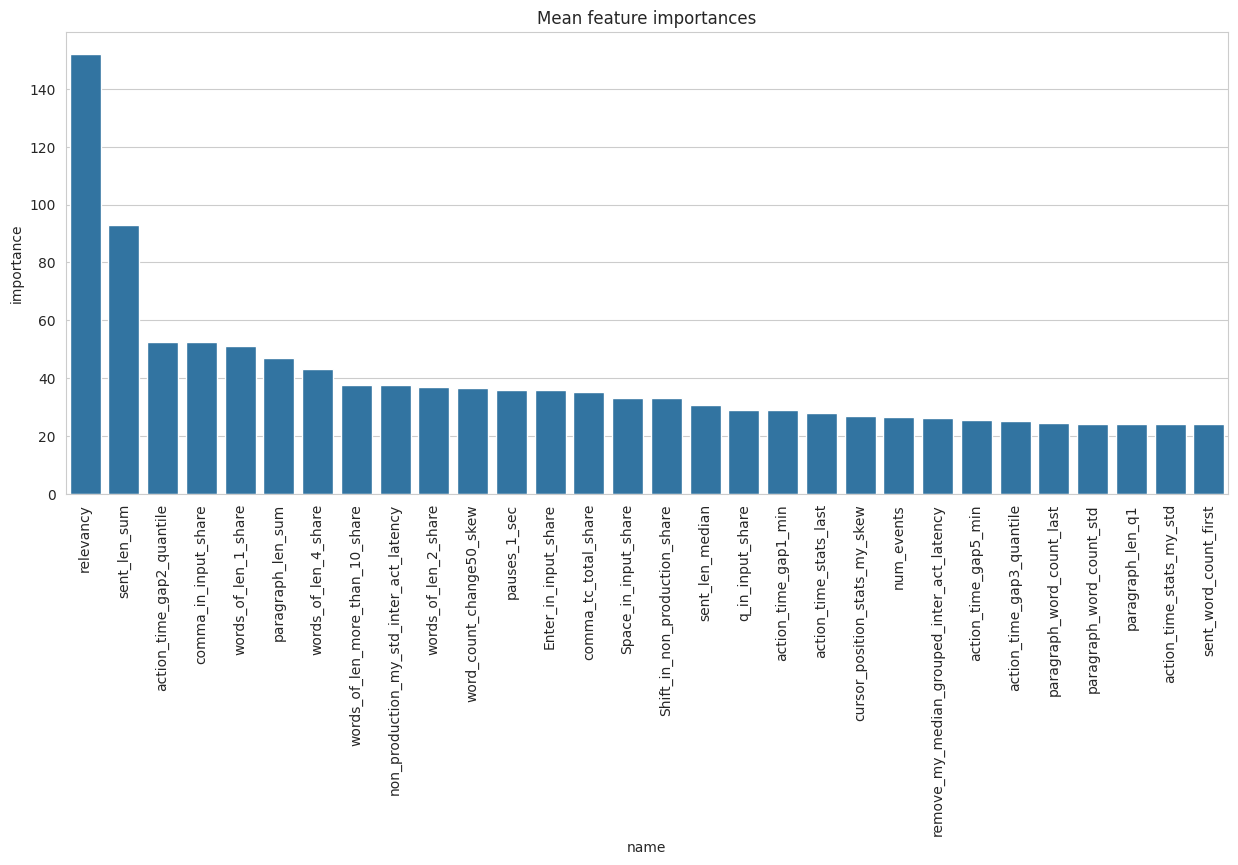

In [63]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(30), x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [244]:
# test_predict_list

In [245]:
test_feats["score"] = np.mean(test_predict_list, axis=0)

In [246]:
test_feats[["id", "score"]].to_csv("submission.csv", index=False)